# Menu <a class="anchor" id="menu"></a>
* [1. Exploratory Data Analysis (EDA)](#eda)
* [2. Experimenting various models](#models)
    * [2.0 Preparing the dataset](#models_prepare)
    * [2.1 DummyClassifier](#models_dummy)
    * [2.2 Logistic Regression](#models_linear)
    * [2.3 Decision Tree](#models_decision_tree)
    * [2.4 Random Forest](#models_random_forest)
    * [2.5 XGBoost](#models_xgboost)
* [3. Impoving the models with GreadSearchCV](#models_grid)
    * [3.1 Logistic Regression Grid](#models_linear_grid)
    * [3.2 Decision Tree Grid](#models_decision_tree_grid)
    * [3.3 Random Forest Grid](#models_random_forest_grid)
    * [3.4 XGBoost Grid](#models_xgboost_grid)
* [4. Solving the problem imbalanced TARGET with class_weigth](#models_balanced)
    * [4.1 Logistic Regression](#models_linear_balanced)
    * [4.2 Decision Tree](#models_decision_tree_balanced)
    * [4.3 Random Forest](#models_random_forest_balanced)
    * [4.4 XGBoost Classifier](#models_xgboost_balanced)
* [5. Solving the problem imbalanced TARGET with SMOT](#models_smot)
    * [5.1 Logistic Regression](#models_linear_smot)
    * [5.2 Decision Tree](#models_decision_tree_smot)
    * [5.3 Random Forest](#models_random_forest_smot)
    * [5.4 XGBoost Classifier](#models_xgboost_smot)
* [6. Impoving the models with extra Features](#models_feature_engineering)
    * [6.0 Feature Engineering](#feature_engineering)
    * [6.1 Logistic Regression](#models_linear_balanced_feature)
    * [6.2 Decision Tree](#models_decision_tree_balanced_feature)
    * [6.3 Random Forest](#models_random_forest_balanced_feature)
    * [6.4 XGBoost Classifier](#models_xgboost_balanced_feature)

In [1]:
import time
import copy as cp
from collections import defaultdict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from zipfile import ZipFile

#### ---- Let's load the columns selected in the EDA ----

In [2]:
filename = 'data/dtypes_low.csv'

dtypes_df = pd.read_csv(filename, sep=',', index_col=0)

cols_to_keep = dtypes_df.columns
dtypes = dtypes_df.to_dict('records')[0]

#### \<test>

#### \<\test>

In [3]:
zip_file = ZipFile('data/Projet+Mise+en+prod+-+home-credit-default-risk.zip')

In [4]:
data_application_train = pd.read_csv(
    zip_file.open('application_train.csv'),
    #dtype=dtypes, 
    ######usecols=cols_to_keep,
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

pd.options.display.max_columns = data_application_train.shape[0]
pd.options.display.max_rows = 100

data_application_train.shape

(307511, 122)

#### \<test>

#### \<\test>

## Feature Engigeering

In [5]:
sample_size_base = 30000
sample_size_grid = 10000
data_clean = data_application_train[:sample_size_base].copy()

In [6]:
import missingno as msno

# Experimenting various models <a class="anchor" id="models"></a> [⇪](#menu)

## 0. Preparing the dataset <a class="anchor" id="models_prepare"></a> [⇪](#menu)

### Splitting the dataset between `train`, `validation` and `test` sets

- The `training set` is used to train various models.
- The `validation set` is used to select a model: we choose the one with the best performance on this set.
- The `test set` is used to estimate the generalization performance of the selected model.

Alternatively, instead of creating those three sets, we can separate the data into only two parts: a `training set` and a `test set` and then do a cross-validation on the `training set`. This allows us to choose a model (the one with the best performance), which we will then train on the whole `training set` and test on the `test set`. It is this final performance that is the best approximation of the performance that the model will be able to achieve on new data.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_full = data_clean.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_clean['TARGET']

In [9]:
#X_train_full, X_test, y_train_full, y_test = train_test_split(
X_train, X_test, y_train, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.10,
                                                random_state=0,
                                                stratify=Y_full)

### Encoding the qualitative variables

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

In [11]:
#oe_targets = [x for x in X_train_full.select_dtypes(exclude='number').columns if X_train_full[x].nunique() == 2]
#ohe_targets = [x for x in X_train_full.select_dtypes(exclude='number').columns if X_train_full[x].nunique() > 2]

oe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() == 2]
ohe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() > 2]

In [12]:
def fit_labels(data):
    """ Prepare the encoder for the ordinal columns.
    - Columns with 2 unique values are encoded using an OrdinalEncoder
    - Columns with more than 2 unique values are encoded using a OneHotEncoder
        
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset used as reference for the label encoders
        
    Returns
    -------
    OrdinalEncoder
        the OE instance used to encode columns with 2 unique values
    OneHotEncoder
        the OHE instance used to encode columns with 3+ unique values
    """
    
    oe_targets = []
    ohe_targets = []
    
    for col in data.select_dtypes(exclude='number').columns:
        if data[col].nunique() == 2:
            oe_targets.append(col)
        else:
            ohe_targets.append(col)
        
    # OrdinalEncoder
    oe = OrdinalEncoder()
    oe.fit(data[oe_targets])
    
    # OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[ohe_targets])
    
    return oe, ohe

def transform_labels(data, oe_model, ohe_mode):
    """ Transform the provided dataset using the provided encoders.
            
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset that needs to be label encoded
        
    Returns
    -------
    DataFrame
        a new dataframe with the encoded labels instead of the non encoded ones
    """
    dt = data.copy()
    
    # OrdinalEncoder
    dt[oe_model.feature_names_in_] = oe_model.transform(dt[oe_model.feature_names_in_])
    
    # OneHotEncoder
    array_hot_encoded = ohe_model.transform(dt[ohe_model.feature_names_in_])
    data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dt.index, columns=ohe_model.get_feature_names_out())
    data_other_cols = dt.drop(columns=ohe_model.feature_names_in_)
    dt = pd.concat([data_hot_encoded, data_other_cols], axis=1)
    
    return dt

#### Fit the encoders

In [13]:
oe_model, ohe_model = fit_labels(X_train)

#### Transform the `training`, `validation` and `testing` sets

In [14]:
#X_train_full = transform_labels(X_train_full, oe_model, ohe_model)
X_train = transform_labels(X_train, oe_model, ohe_model)
#X_valid = transform_labels(X_valid, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)

### Imputations

In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [16]:
def fit_imputer(data, columns):
    
    imputer = SimpleImputer(strategy='median')
    #imputer = IterativeImputer(
    #    imputation_order='ascending', 
    #    random_state=0, 
        #min_value=0, 
        #max_value=max_values_imput
    #    n_nearest_features = 10,
    #)
    imputer.fit(data[columns])
    
    return imputer

def impute(data, imputer):
    
    dt = data.copy()
    dt_imput = pd.DataFrame(imputer.transform(dt[imputer.feature_names_in_]), index=dt.index, columns=imputer.feature_names_in_)
    dt[imputer.feature_names_in_] = dt_imput
    print(dt.shape, type(dt))
    
    return dt

In [17]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

In [18]:
#X_train_full = impute(X_train_full, imputer_model)
X_train = impute(X_train, imputer_model)
#X_valid = impute(X_valid, imputer_model)
X_test = impute(X_test, imputer_model)

(27000, 242) <class 'pandas.core.frame.DataFrame'>
(3000, 242) <class 'pandas.core.frame.DataFrame'>


<AxesSubplot:>

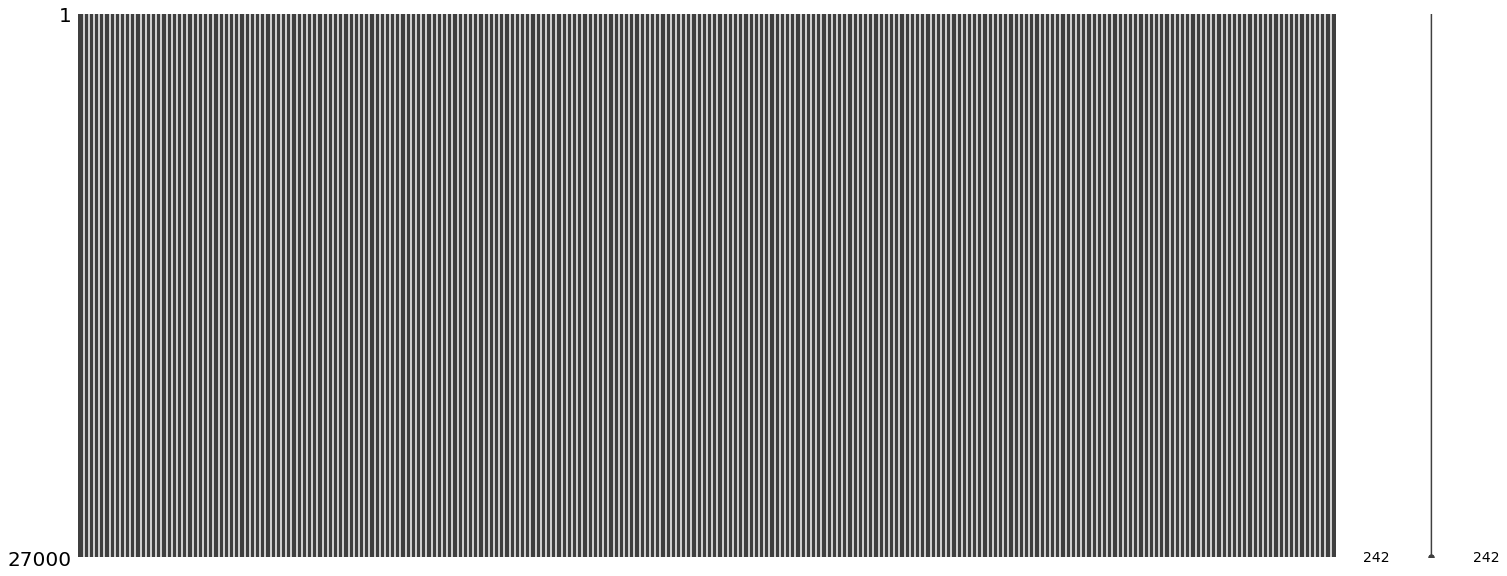

In [19]:
msno.matrix(X_train)

### Normalizing the dataset

Some machine learning algorithms are sensitive to feature scaling *(Gradient Descent Based Algorithms, Distance-Based Algorithms)* while others *(Tree-Based Algorithms...)* are virtually invariant to it. But as we will try manuy different ML algorithms, we will apply it to our datasets.

In [20]:
from sklearn.preprocessing import RobustScaler

In [21]:
def fit_normalizer(data):
       
    robust_scaler = RobustScaler()
    robust_scaler.fit(data)
    
    return robust_scaler

def normalize(data, robust_scaler):
    
    dt = data.copy()
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

In [22]:
model_scaler = fit_normalizer(X_train)

In [23]:
#X_train_full = normalize(X_train_full, model_scaler)
X_train = normalize(X_train, model_scaler)
#X_valid = normalize(X_valid, model_scaler)
X_test = normalize(X_test, model_scaler)

### Define some report functions

In [24]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, average_precision_score

In [25]:
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---\n\n", report)

In [26]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---\n")
    plt.show()

In [27]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- ROC AUC ---\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            roc_score = roc_auc_score(y_true, y_pred)
            sorted_scores[model_name] = roc_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)
    
    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [28]:
from sklearn.metrics import precision_recall_curve

def print_prauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- PRECISION RECALL AUC ---\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            pr_score = average_precision_score(y_true, y_pred)
            sorted_scores[model_name] = pr_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)

    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        pr_score = average_precision_score(y_true, y_pred)
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        
        ax.plot(recall, precision, label=f"{model_name} ({pr_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = pr_score
        
    no_skill = len(y_true[y_true==1]) / len(y_true)            
    ax.plot([0, 1], [no_skill, no_skill], label='No skill', linestyle='--', color='red', alpha=0.3)
    ax.plot([1, 0], [0, 1], label='Balanced', linestyle='--', color='green', alpha=0.5)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [29]:
def save_score(method_name, threshold, param_grid, training_time, inference_time, **scores):
    
    idx = np.where(scores_df.Method == method_name)[0]        
    idx = idx[0] if idx.size > 0 else len(scores_df.index)
    
    rocauc_value = scores.get('roc_auc', None)
    f1_value =  scores.get('f1', None)
    accuracy_value =  scores.get('accuracy', None)
    precision_value =  scores.get('precision', None)
    recall_value = scores.get('recall', None)
    prauc_value = scores.get('average_precision', None)
    TP = scores.get('TP', None)
    FP = scores.get('FP', None)
    TN = scores.get('TN', None)
    FN = scores.get('FN', None)
    
    scores_df.loc[idx] = [method_name, threshold, param_grid, rocauc_value, prauc_value, f1_value, accuracy_value, precision_value, recall_value, TP, TN, FP, FN, training_time, inference_time]    
    scores_df.to_csv(scores_path, index=False)

In [30]:
scores_df = pd.DataFrame(columns=['Method', 'threshold', 'params', 'ROC AUC', 'PR AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'TP', 'TN', 'FP', 'FN', 'Training time', 'Inference time'])
y_preds = {}
scores_path = 'data/scores.csv'
scores_df.to_csv(scores_path, index=False)

def get_scores(method_name, model, X_ref=None, y_ref=None, param_grid=None, threshold=None, training_time=None, inference_time=None, register=False, simple=False, show_classification=True, show_confusion=True, show_roccurves=True, **scores):
    
    if X_ref is None:
        X_ref = X_test
        
    if y_ref is None:
        y_ref = y_test
    
    y_pred, y_pred_proba, inference_time = predict(model, X_ref, threshold)
    cm = confusion_matrix(y_ref, y_pred, labels=[0,1])

    scores = {
        'roc_auc': roc_auc_score(y_ref, y_pred_proba),
        'f1': f1_score(y_ref, y_pred),
        'accuracy': accuracy_score(y_ref, y_pred),
        'precision': precision_score(y_ref, y_pred, zero_division=0),
        'recall': recall_score(y_ref, y_pred),
        'average_precision': average_precision_score(y_ref, y_pred_proba),
        'TN': cm[0][0],
        'FP': cm[0][1],
        'FN': cm[1][0],
        'TP': cm[1][1],
    }
    
    # Register score and replace if it already exists
    if register:
        save_score(method_name, threshold, param_grid, training_time, inference_time, **scores)
    
    # Basic report
    scores_str = ""
    for key in scores.keys():
        if type(scores[key]) == np.float64 and key not in ['TP','TN','FP','FN']:
            scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"
    print(f"--- {method_name} ---\n\n{scores_str}")
          
    if simple:
        return
    
    print('-'*100,'The informations below this line are based on the best estimator of the cross-validation'.center(100,), '-'*100, sep='\n', end='\n\n')
    
    # Classification report
    if show_classification:
        print_classification_report(y_ref, y_pred)
    
    # Confusion Matrix
    if show_confusion:
        print_confusion_matrix(y_ref, y_pred)
    
    # ROC AUC curves
    if show_roccurves:
        y_preds[method_name] = y_pred_proba
        print_rocauc(y_ref, y_preds)
        print_prauc(y_ref, y_preds)

In [31]:
def predict(model, X_ref, threshold=None):
    t0 = time.perf_counter()
    
    y_pred_proba = model.predict_proba(X_ref)[:,1]
    if threshold:
        y_pred = get_labels_from_threshold(y_pred_proba, threshold)
    else:
        y_pred = model.predict(X_ref)
    
    tt = time.perf_counter() - t0
    return y_pred, y_pred_proba, tt

In [32]:
def get_labels_from_threshold(y_proba, threshold):
    return (y_proba >= threshold).astype('int')

def find_best_threshold(model, X_valid, y_valid, eval_function ):

    best_threshold = 0.0
    best_score = 0.0
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    
    for threshold in np.arange(0, 1, 0.001):
        
        y_pred_threshold = get_labels_from_threshold(y_pred_proba, threshold)
        
        score = eval_function(y_valid, y_pred_threshold)
        if score >= best_threshold:
            best_threshold = threshold
            best_score = score
        
    return best_score, best_threshold

In [33]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV  # --> ne supporte pas le multi-scoring
from sklearn.model_selection import GridSearchCV


def fit_model(model_name, model, X_ref=None, y_ref=None, param_grid = {}, scoring='roc_auc', cv=5, verbose=2, register=True):
    
    if X_ref is None:
        X_ref = X_train
        
    if y_ref is None:
        y_ref = y_train
        
    #if scoring == "custom":
    #    scorers = make_scorer(my_loss, greater_is_better=False)
    #else:
    #    scorers = scoring
        
    fit_time = time.perf_counter()
    grid_model = HalvingGridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, min_resources=500)
    #grid_model = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, refit="roc_auc", return_train_score=True)
    grid_model.fit(X_ref, y_ref)
    fit_time = time.perf_counter() - fit_time

    results = grid_model.cv_results_
    n_splits = cv.n_splits if hasattr(cv, 'n_splits') else cv
    sets_list = ["test"] if verbose < 3 else ["train", "test"]
    
    # Print K-fold scores
    if verbose > 1:
        for i in range(n_splits):
            print(f"".center(100,'-'))
        
            for sample in sets_list:
                scores_str = f"{scoring.upper()}: {results[f'split{i}_{sample}_score'].mean():.4f}"
                print(f"FOLD-{i+1} {sample.upper().rjust(6)} scores | {scores_str}")
                
    # Print overall scores
    if verbose > 0:
   
        for sample in sets_list:
            print('\n', f" {sample.upper()}-CV-SPLIT MEAN SCORES ".center(100,'-'), sep='')
            mean_str = f"{scoring.upper()}: {results[f'mean_{sample}_score'].mean():.4f} (std:{results[f'std_{sample}_score'].mean():.4f})"
            print(f"\n- {mean_str}")
            
        print("\n", f"".center(100,'-'), sep='')
        
    #scores_args = defaultdict(list)
    #for scorer in scoring:
    #    scores_args[scorer] = results[f'mean_test_{scorer}'].mean()             
    
    inf_time = pd.Series(grid_model.cv_results_['mean_score_time']).mean()
    
    # Register score and replace if it already exists
    #if register:
    #    save_score(f"{model_name} CV", None, param_grid, fit_time, inf_time, **scores_args)
    
    return {'grid':grid_model, 'model':grid_model.best_estimator_, 'training_time':fit_time, 'inference_time':inf_time, 'param_grid':param_grid} #, **scores_args}

In [34]:
def get_model_name(model):
    index = str(model).index('(')
    return str(model)[:index]

#### Let's define the cross-validation method

In [35]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [36]:
import FreeMobileSMS as sms
sms.send("Data preparation done", stop=False)

## 1. Establishing baseline with Dummy Classifier <a class="anchor" id="models_dummy"></a> [⇪](#menu)

In [37]:
from sklearn.dummy import DummyClassifier

In [38]:
model_name = "DummyClassifier"

In [39]:
grd_dummy = fit_model( 
    model_name,
    DummyClassifier(),
    param_grid={ 'random_state':[0], 'strategy':['stratified'] }, 
    cv = skfold,
    verbose=2,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.4516
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.4526
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.4531
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.4536
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5621

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.4746 (std:0.0437)

----------------------------------------------------------------------------------------------------


--- DummyClassifier ---

             ROC_AUC : 0.4897
                  F1 : 0.0690
            ACCURACY : 0.8380
           PRECISION : 0.0638
              RECALL : 0.0750
   AVERAGE_PRECISION : 0.0788

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.90      0.91      2760
Prediction = 1       0.06      0.07      0.07       240

      accuracy                           0.84      3000
     macro avg       0.49      0.49      0.49      3000
  weighted avg       0.85      0.84      0.84      3000

--- Confusion Matrix ---



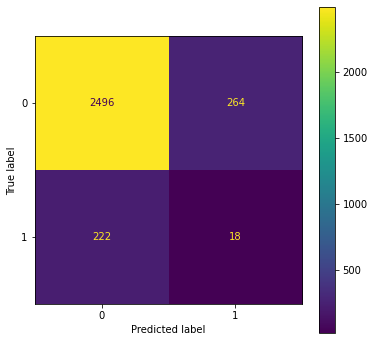

--- ROC AUC ---



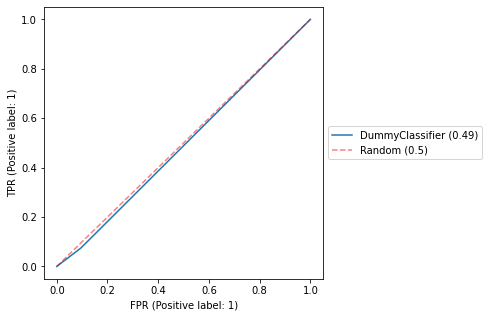

--- PRECISION RECALL AUC ---



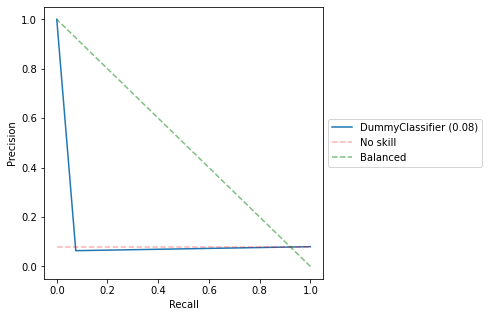

In [40]:
get_scores(model_name, **grd_dummy, register=True)

> - The **recall** means "how many of this class you find over the whole number of element of this class"
> - The **precision** will be "how many are correctly classified among that class"
> - The **f1-score** is the harmonic mean between precision & recall
> - The **support** is the number of occurence of the given class in your dataset


## 2. Logistic Regression <a class="anchor" id="models_linear"></a> [⇪](#menu)

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
model_name = "Basic LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid={ 'random_state':[0], 'max_iter':[3000] },  
    cv = skfold,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6947
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5571
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6966
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6080
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.4943

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6101 (std:0.0786)

----------------------------------------------------------------------------------------------------


/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Basic LogisticRegression ---

             ROC_AUC : 0.7457
                  F1 : 0.0000
            ACCURACY : 0.9187
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.2083

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.00      0.00      0.00       240

      accuracy                           0.92      3000
     macro avg       0.46      0.50      0.48      3000
  weighted avg       0.85      0.92      0.88      3000

--- Confusion Matrix ---



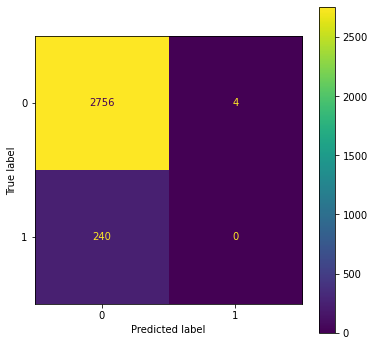

--- ROC AUC ---



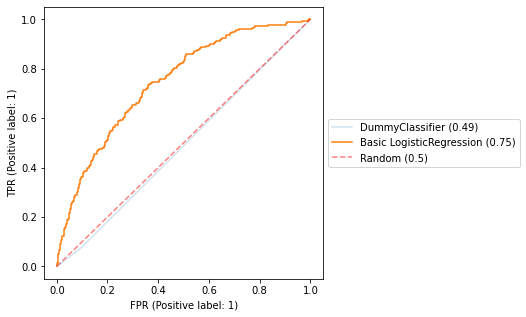

--- PRECISION RECALL AUC ---



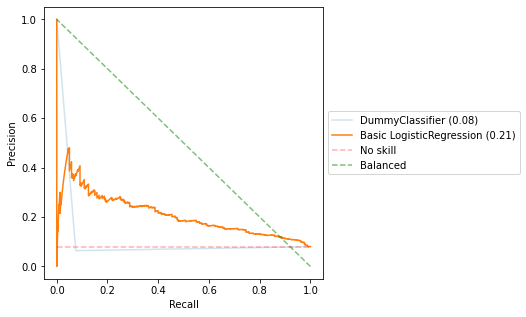

In [43]:
get_scores(model_name, **grd_log, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [44]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.24166908142567373) for this model is reached with a threshold of 0.241


--- Basic LogisticRegression [w/thresholding] ---

             ROC_AUC : 0.7457
                  F1 : 0.2100
            ACCURACY : 0.8997
           PRECISION : 0.2837
              RECALL : 0.1667
   AVERAGE_PRECISION : 0.2083

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.96      0.95      2760
Prediction = 1       0.28      0.17      0.21       240

      accuracy                           0.90      3000
     macro avg       0.61      0.57      0.58      3000
  weighted avg       0.88      0.90      0.89      3000

--- Confusion Matrix ---



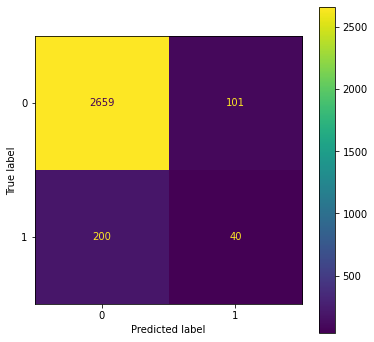

In [45]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Decision Tree <a class="anchor" id="models_decision_tree"></a> [⇪](#menu)

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
model_name = "Basic DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid={ 'random_state':[0] }, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.4341
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5015
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.4462
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5167
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5647

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.4926 (std:0.0478)

----------------------------------------------------------------------------------------------------


--- Basic DecisionTreeClassifier ---

             ROC_AUC : 0.5306
                  F1 : 0.1382
            ACCURACY : 0.8503
           PRECISION : 0.1281
              RECALL : 0.1500
   AVERAGE_PRECISION : 0.0872

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.91      0.92      2760
Prediction = 1       0.13      0.15      0.14       240

      accuracy                           0.85      3000
     macro avg       0.53      0.53      0.53      3000
  weighted avg       0.86      0.85      0.86      3000

--- Confusion Matrix ---



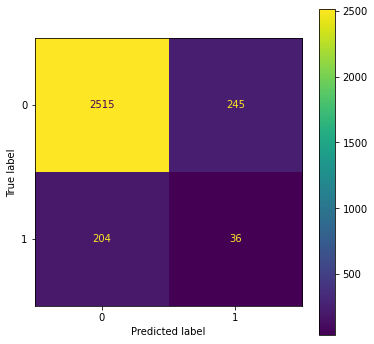

--- ROC AUC ---



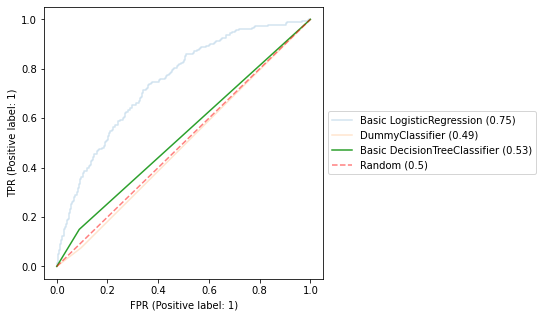

--- PRECISION RECALL AUC ---



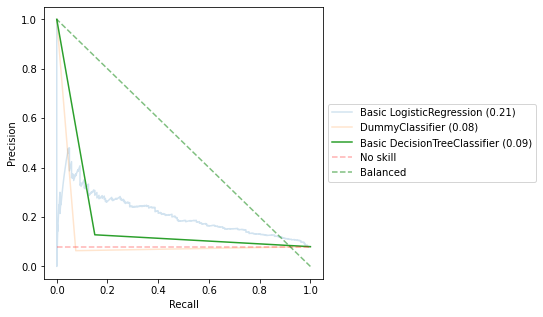

In [48]:
get_scores(model_name, **grd_dt, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [49]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (1.0) for this model is reached with a threshold of 0.999


--- Basic DecisionTreeClassifier [w/thresholding] ---

             ROC_AUC : 0.5306
                  F1 : 0.1382
            ACCURACY : 0.8503
           PRECISION : 0.1281
              RECALL : 0.1500
   AVERAGE_PRECISION : 0.0872

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.91      0.92      2760
Prediction = 1       0.13      0.15      0.14       240

      accuracy                           0.85      3000
     macro avg       0.53      0.53      0.53      3000
  weighted avg       0.86      0.85      0.86      3000

--- Confusion Matrix ---



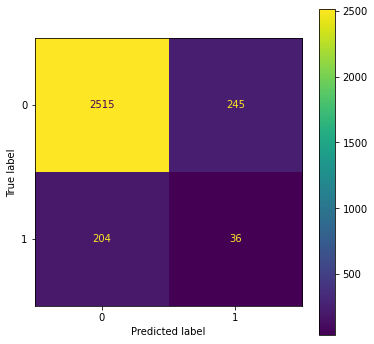

In [50]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 4. Random Forest <a class="anchor" id="models_random_forest"></a> [⇪](#menu)

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
model_name = "Basic RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid={ 'random_state':[0] }, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6356
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5815
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6359
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5253
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6350

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6027 (std:0.0440)

----------------------------------------------------------------------------------------------------


--- Basic RandomForestClassifier ---

             ROC_AUC : 0.6987
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1774

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.00      0.00      0.00       240

      accuracy                           0.92      3000
     macro avg       0.46      0.50      0.48      3000
  weighted avg       0.85      0.92      0.88      3000

--- Confusion Matrix ---



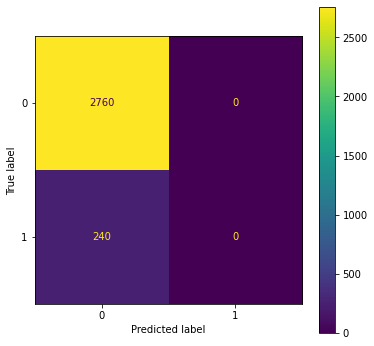

--- ROC AUC ---



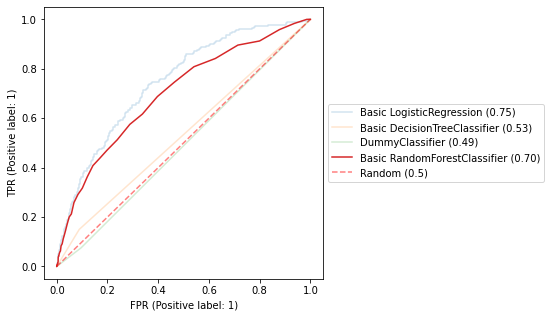

--- PRECISION RECALL AUC ---



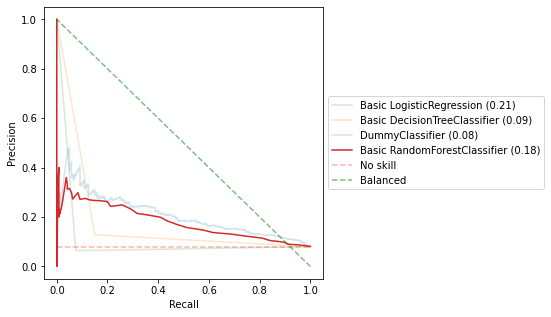

In [53]:
get_scores(model_name, **grd_rf, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [54]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.7246462264150944) for this model is reached with a threshold of 0.68


--- Basic RandomForestClassifier [w/thresholding] ---

             ROC_AUC : 0.6987
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1774

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.00      0.00      0.00       240

      accuracy                           0.92      3000
     macro avg       0.46      0.50      0.48      3000
  weighted avg       0.85      0.92      0.88      3000

--- Confusion Matrix ---



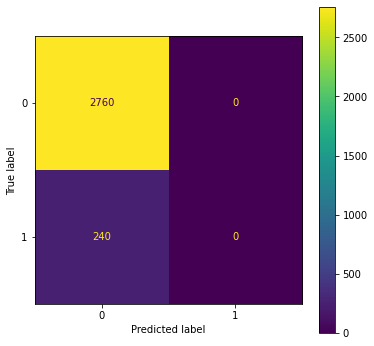

In [55]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 5. XGBoost Classifier <a class="anchor" id="models_xgboost"></a> [⇪](#menu)

In [56]:
from xgboost import XGBClassifier

In [57]:
model_name = "Basic XGBClassifier"

param_grid = {
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
}

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7242
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7021
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5213
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5355
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5225

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6011 (std:0.0919)

----------------------------------------------------------------------------------------------------


--- Basic XGBClassifier ---

             ROC_AUC : 0.7354
                  F1 : 0.0455
            ACCURACY : 0.9160
           PRECISION : 0.2500
              RECALL : 0.0250
   AVERAGE_PRECISION : 0.2003

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      2760
Prediction = 1       0.25      0.03      0.05       240

      accuracy                           0.92      3000
     macro avg       0.59      0.51      0.50      3000
  weighted avg       0.87      0.92      0.88      3000

--- Confusion Matrix ---



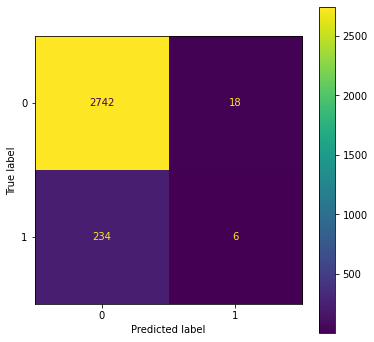

--- ROC AUC ---



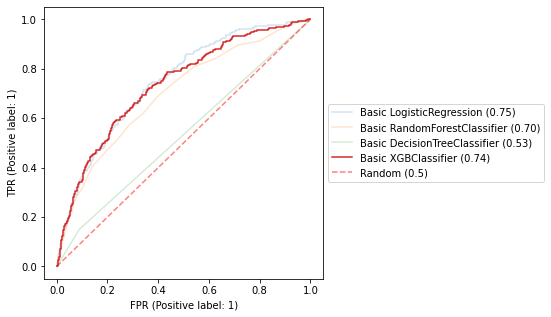

--- PRECISION RECALL AUC ---



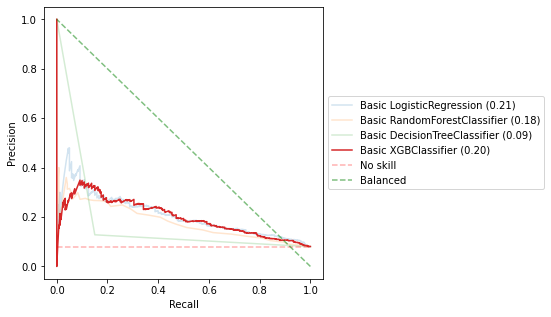

In [58]:
get_scores(model_name, **grd_xgb, register=True)

#### Let's find the best threshold *(basedœm on F1 score)*

In [59]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.5623130608175473) for this model is reached with a threshold of 0.561


--- Basic XGBClassifier [w/thresholding] ---

             ROC_AUC : 0.7354
                  F1 : 0.0309
            ACCURACY : 0.9163
           PRECISION : 0.2105
              RECALL : 0.0167
   AVERAGE_PRECISION : 0.2003

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      2760
Prediction = 1       0.21      0.02      0.03       240

      accuracy                           0.92      3000
     macro avg       0.57      0.51      0.49      3000
  weighted avg       0.86      0.92      0.88      3000

--- Confusion Matrix ---



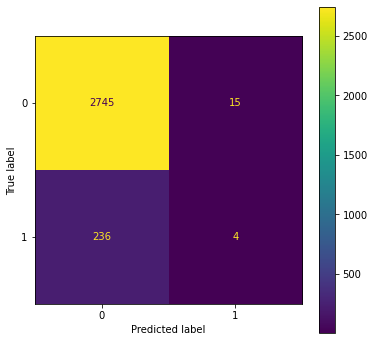

In [60]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 6. KNN *(k-nearest neighbors)* <a class="anchor" id="models_knn"></a> [⇪](#menu)

In [61]:
from sklearn.neighbors import KNeighborsClassifier

In [62]:
model_name = "Basic KNeighborsClassifier"

grd_knn = fit_model(
    model_name,
    KNeighborsClassifier(n_jobs=-1), 
    param_grid={},  
    cv = skfold,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.4726
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7021
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7004
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.3871
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5376

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5599 (std:0.1249)

----------------------------------------------------------------------------------------------------


--- Basic KNeighborsClassifier ---

             ROC_AUC : 0.5803
                  F1 : 0.0297
            ACCURACY : 0.9130
           PRECISION : 0.1379
              RECALL : 0.0167
   AVERAGE_PRECISION : 0.1016

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.95      2760
Prediction = 1       0.14      0.02      0.03       240

      accuracy                           0.91      3000
     macro avg       0.53      0.50      0.49      3000
  weighted avg       0.86      0.91      0.88      3000

--- Confusion Matrix ---



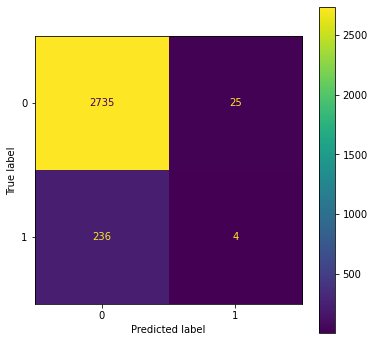

--- ROC AUC ---



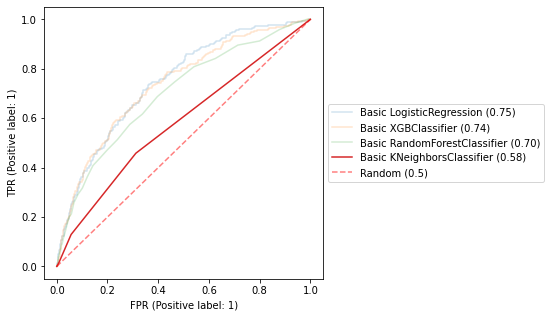

--- PRECISION RECALL AUC ---



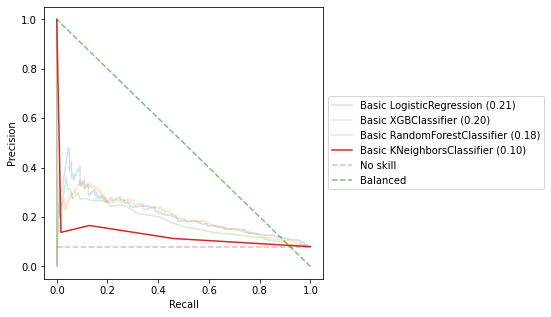

In [63]:
get_scores(model_name, **grd_knn, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [64]:
f1_value, best_threshold = find_best_threshold(grd_knn['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.41171974522293) for this model is reached with a threshold of 0.4


--- Basic KNeighborsClassifier [w/thresholding] ---

             ROC_AUC : 0.5803
                  F1 : 0.1452
            ACCURACY : 0.8783
           PRECISION : 0.1658
              RECALL : 0.1292
   AVERAGE_PRECISION : 0.1016

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.94      0.93      2760
Prediction = 1       0.17      0.13      0.15       240

      accuracy                           0.88      3000
     macro avg       0.55      0.54      0.54      3000
  weighted avg       0.86      0.88      0.87      3000

--- Confusion Matrix ---



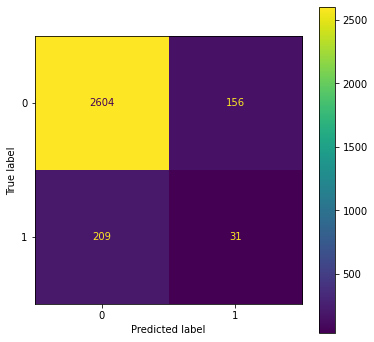

In [65]:
get_scores(f"{model_name} [w/thresholding]", **grd_knn, threshold=best_threshold, register=True, show_roccurves=False)

## 7. Review scores <a class="anchor" id="models_scores"></a> [⇪](#menu)

In [66]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier,None,"{'random_state': [0], 'strategy': ['stratified']}",0.489674,0.078787,0.068966,0.838000,0.063830,0.075000,18,2496,264,222,1.208840,0.002087
1,Basic LogisticRegression,None,"{'random_state': [0], 'max_iter': [3000]}",0.745713,0.208292,0.000000,0.918667,0.000000,0.000000,0,2756,4,240,47.455576,0.024607
2,Basic LogisticRegression [w/thresholding],0.241,"{'random_state': [0], 'max_iter': [3000]}",0.745713,0.208292,0.209974,0.899667,0.283688,0.166667,40,2659,101,200,47.455576,0.004775
3,Basic DecisionTreeClassifier,None,{'random_state': [0]},0.530616,0.087217,0.138196,0.850333,0.128114,0.150000,36,2515,245,204,2.508329,0.010776
4,Basic DecisionTreeClassifier [w/thresholding],0.999,{'random_state': [0]},0.530616,0.087217,0.138196,0.850333,0.128114,0.150000,36,2515,245,204,2.508329,0.005019
5,Basic RandomForestClassifier,None,{'random_state': [0]},0.698664,0.177358,0.000000,0.920000,0.000000,0.000000,0,2760,0,240,2.883787,0.117337
6,Basic RandomForestClassifier [w/thresholding],0.68,{'random_state': [0]},0.698664,0.177358,0.000000,0.920000,0.000000,0.000000,0,2760,0,240,2.883787,0.069008
7,Basic XGBClassifier,None,"{'seed': [0], 'objective': ['binary:logistic']...",0.735420,0.200251,0.045455,0.916000,0.250000,0.025000,6,2742,18,234,8.793611,0.032197
8,Basic XGBClassifier [w/thresholding],0.561,"{'seed': [0], 'objective': ['binary:logistic']...",0.735420,0.200251,0.030888,0.916333,0.210526,0.016667,4,2745,15,236,8.793611,0.019872
9,Basic KNeighborsClassifier,None,{},0.580269,0.101572,0.029740,0.913000,0.137931,0.016667,4,2735,25,236,0.232196,4.742763


In [67]:
scores_df[['Method', 'ROC AUC', 'F1 score', 'Recall']]

,Method,ROC AUC,F1 score,Recall
0,DummyClassifier,0.489674,0.068966,0.075000
1,Basic LogisticRegression,0.745713,0.000000,0.000000
2,Basic LogisticRegression [w/thresholding],0.745713,0.209974,0.166667
3,Basic DecisionTreeClassifier,0.530616,0.138196,0.150000
4,Basic DecisionTreeClassifier [w/thresholding],0.530616,0.138196,0.150000
5,Basic RandomForestClassifier,0.698664,0.000000,0.000000
6,Basic RandomForestClassifier [w/thresholding],0.698664,0.000000,0.000000
7,Basic XGBClassifier,0.735420,0.045455,0.025000
8,Basic XGBClassifier [w/thresholding],0.735420,0.030888,0.016667
9,Basic KNeighborsClassifier,0.580269,0.029740,0.016667


In [68]:
sms.send("Basic done", stop=False)

# Improving the models with GridSearchCV <a class="anchor" id="models_grid"></a> [⇪](#menu)

## 1. Logistic Regression Grid<a class="anchor" id="models_linear_grid"></a> [⇪](#menu)

In [69]:
param_grid = [
    {
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [70]:
model_name = "Grid LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6451
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5835
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5646
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6073
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5945

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5990 (std:0.0661)

----------------------------------------------------------------------------------------------------


In [71]:
grd_log['grid'].best_params_

{'C': 0.01,
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs'}

--- Grid LogisticRegression ---

             ROC_AUC : 0.7443
                  F1 : 0.0000
            ACCURACY : 0.9197
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.2173

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.00      0.00      0.00       240

      accuracy                           0.92      3000
     macro avg       0.46      0.50      0.48      3000
  weighted avg       0.85      0.92      0.88      3000

--- Confusion Matrix ---



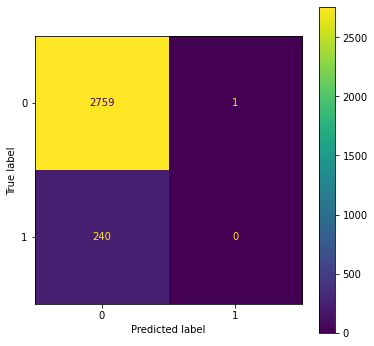

--- ROC AUC ---



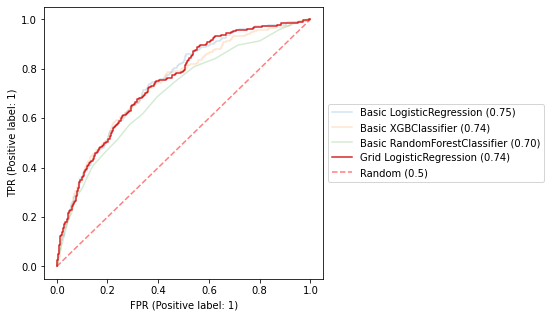

--- PRECISION RECALL AUC ---



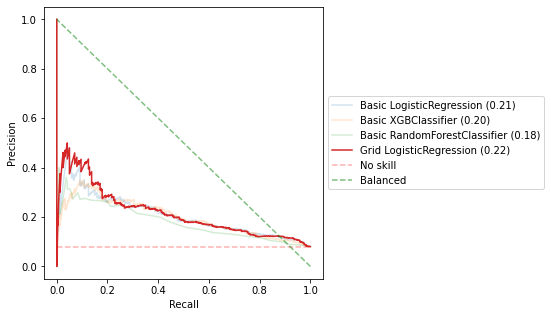

In [72]:
get_scores(model_name, **grd_log, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [73]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.22592152199762186) for this model is reached with a threshold of 0.225


--- Grid LogisticRegression [w/thresholding] ---

             ROC_AUC : 0.7443
                  F1 : 0.2251
            ACCURACY : 0.9013
           PRECISION : 0.3028
              RECALL : 0.1792
   AVERAGE_PRECISION : 0.2173

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.96      0.95      2760
Prediction = 1       0.30      0.18      0.23       240

      accuracy                           0.90      3000
     macro avg       0.62      0.57      0.59      3000
  weighted avg       0.88      0.90      0.89      3000

--- Confusion Matrix ---



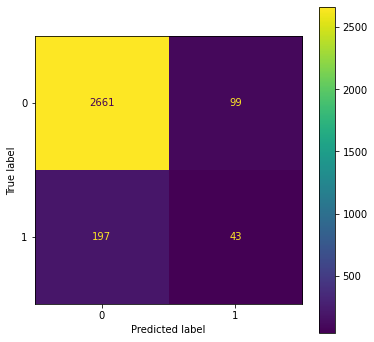

In [74]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 2. Decision Tree Grid <a class="anchor" id="models_decision_tree_grid"></a> [⇪](#menu)

In [75]:
param_grid = {
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [76]:
model_name = "Grid DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5352
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5140
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5650
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5436
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5308

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5377 (std:0.0505)

----------------------------------------------------------------------------------------------------


In [77]:
grd_dt['grid'].best_params_

{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'random_state': 0}

--- Grid DecisionTreeClassifier ---

             ROC_AUC : 0.6744
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1377

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.00      0.00      0.00       240

      accuracy                           0.92      3000
     macro avg       0.46      0.50      0.48      3000
  weighted avg       0.85      0.92      0.88      3000

--- Confusion Matrix ---



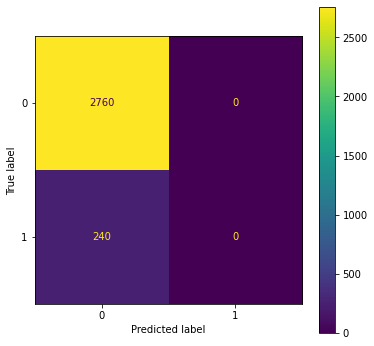

--- ROC AUC ---



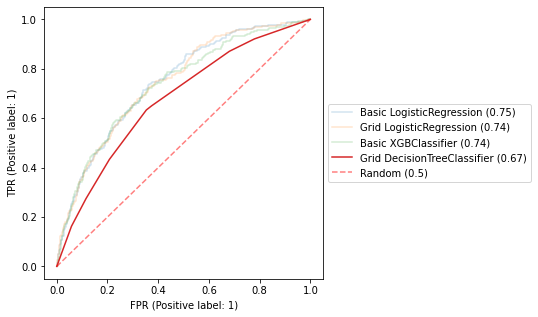

--- PRECISION RECALL AUC ---



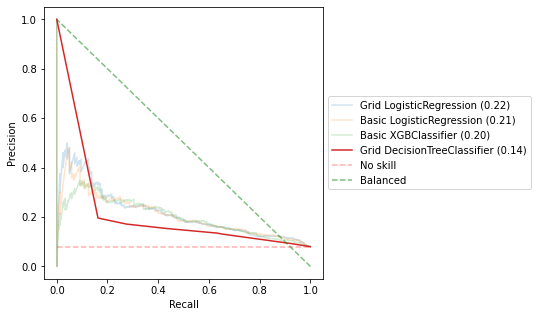

In [78]:
get_scores(model_name, **grd_dt, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [79]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2139938712972421) for this model is reached with a threshold of 0.214


--- Grid DecisionTreeClassifier [w/thresholding] ---

             ROC_AUC : 0.6744
                  F1 : 0.1777
            ACCURACY : 0.8797
           PRECISION : 0.1960
              RECALL : 0.1625
   AVERAGE_PRECISION : 0.1377

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.94      0.94      2760
Prediction = 1       0.20      0.16      0.18       240

      accuracy                           0.88      3000
     macro avg       0.56      0.55      0.56      3000
  weighted avg       0.87      0.88      0.87      3000

--- Confusion Matrix ---



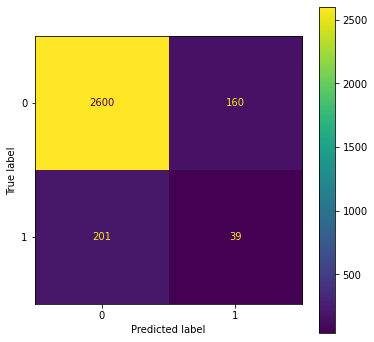

In [80]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Random Forest Grid <a class="anchor" id="models_random_forest_grid"></a> [⇪](#menu)

In [81]:
param_grid = {
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 512]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [82]:
model_name = "Grid RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6565
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6512
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6873
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6927
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5913

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6558 (std:0.0625)

----------------------------------------------------------------------------------------------------


In [83]:
grd_rf['grid'].best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'sqrt',
 'n_estimators': 400,
 'random_state': 0}

--- Grid RandomForestClassifier ---

             ROC_AUC : 0.7227
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.2025

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.00      0.00      0.00       240

      accuracy                           0.92      3000
     macro avg       0.46      0.50      0.48      3000
  weighted avg       0.85      0.92      0.88      3000

--- Confusion Matrix ---



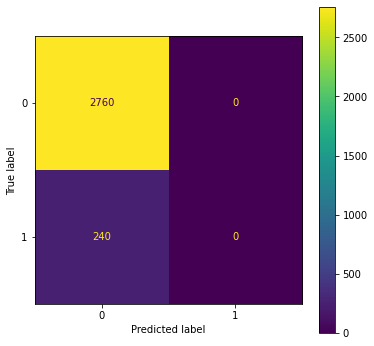

--- ROC AUC ---



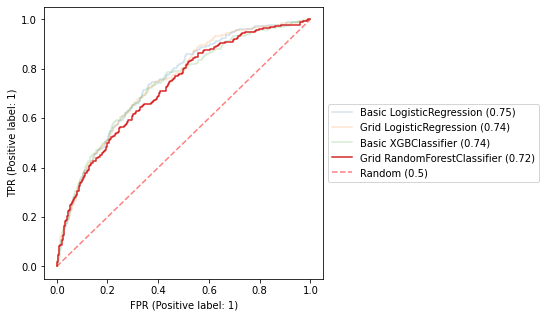

--- PRECISION RECALL AUC ---



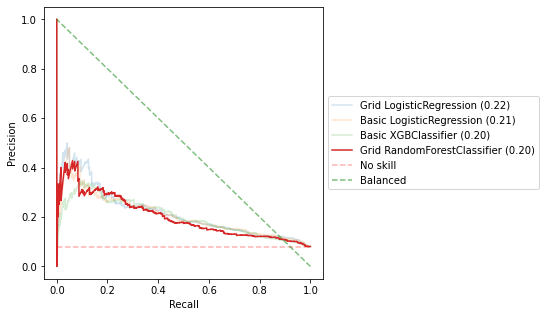

In [84]:
get_scores(model_name, **grd_rf, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [85]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.17996742671009772) for this model is reached with a threshold of 0.17500000000000002


--- Grid RandomForestClassifier [w/thresholding] ---

             ROC_AUC : 0.7227
                  F1 : 0.0467
            ACCURACY : 0.9183
           PRECISION : 0.3529
              RECALL : 0.0250
   AVERAGE_PRECISION : 0.2025

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.35      0.03      0.05       240

      accuracy                           0.92      3000
     macro avg       0.64      0.51      0.50      3000
  weighted avg       0.88      0.92      0.88      3000

--- Confusion Matrix ---



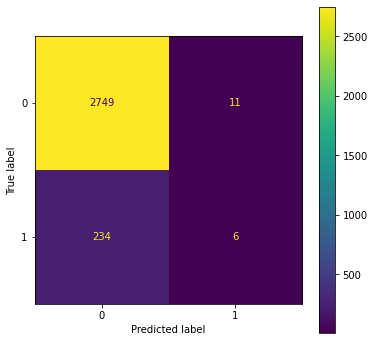

In [86]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 4. XGBoost Classifier Grid<a class="anchor" id="models_xgboost_grid"></a> [⇪](#menu)

In [87]:
from xgboost import XGBClassifier

In [88]:
param_grid = {
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [89]:
model_name = "Grid XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7251
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7288
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5553
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5432
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6193

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6343 (std:0.0926)

----------------------------------------------------------------------------------------------------


In [90]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 180,
 'nthread': -1,
 'objective': 'binary:logistic',
 'seed': 0}

--- Grid XGBClassifier ---

             ROC_AUC : 0.7310
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.2000

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.00      0.00      0.00       240

      accuracy                           0.92      3000
     macro avg       0.46      0.50      0.48      3000
  weighted avg       0.85      0.92      0.88      3000

--- Confusion Matrix ---



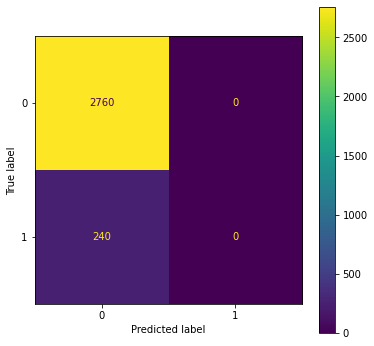

--- ROC AUC ---



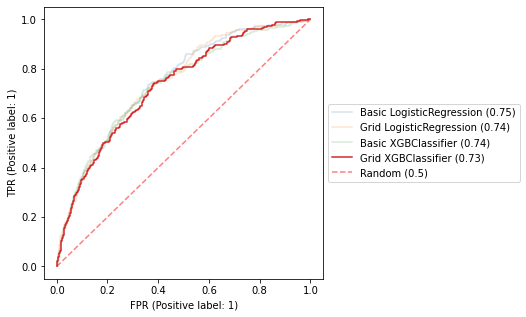

--- PRECISION RECALL AUC ---



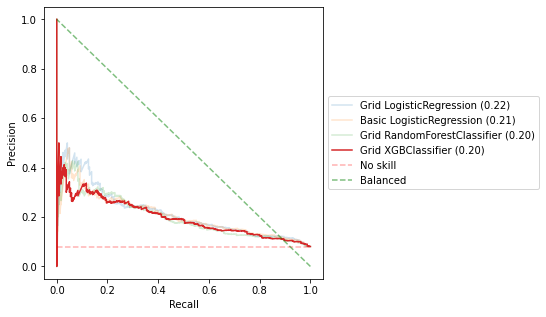

In [91]:
get_scores(model_name, **grd_xgb, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [92]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.22761664564943251) for this model is reached with a threshold of 0.226


--- Grid XGBClassifier [w/thresholding] ---

             ROC_AUC : 0.7310
                  F1 : 0.1932
            ACCURACY : 0.9053
           PRECISION : 0.3036
              RECALL : 0.1417
   AVERAGE_PRECISION : 0.2000

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.97      0.95      2760
Prediction = 1       0.30      0.14      0.19       240

      accuracy                           0.91      3000
     macro avg       0.62      0.56      0.57      3000
  weighted avg       0.88      0.91      0.89      3000

--- Confusion Matrix ---



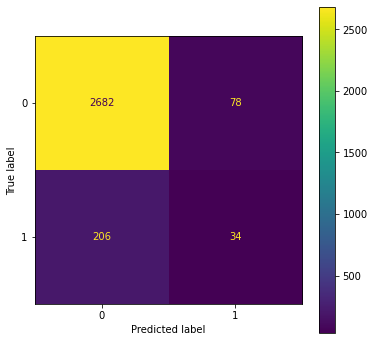

In [93]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 5. KNN *(k-nearest neighbors)* Grid <a class="anchor" id="models_knn_grid"></a> [⇪](#menu)

In [94]:
param_grid = {
    'n_neighbors': list(range(1,35,2)), # tous les chiffres impairs de 1 à 33 inclus
    #'weight_options': ['uniform', 'distance']
}

In [95]:
model_name = "Grid KNeighborsClassifier"

grd_knn = fit_model(
    model_name,
    KNeighborsClassifier(n_jobs=-1), 
    param_grid=param_grid,  
    cv = skfold,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.3939
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5168
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5142
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5734
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5008

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.4998 (std:0.0772)

----------------------------------------------------------------------------------------------------


--- Grid KNeighborsClassifier ---

             ROC_AUC : 0.6088
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1363

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.00      0.00      0.00       240

      accuracy                           0.92      3000
     macro avg       0.46      0.50      0.48      3000
  weighted avg       0.85      0.92      0.88      3000

--- Confusion Matrix ---



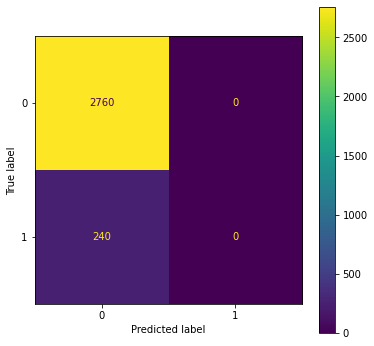

--- ROC AUC ---



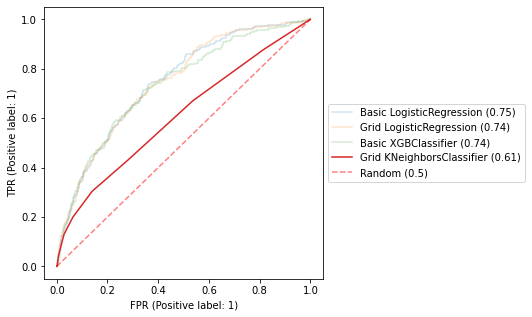

--- PRECISION RECALL AUC ---



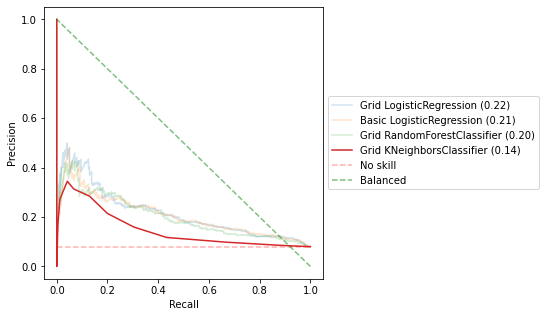

In [96]:
get_scores(model_name, **grd_knn, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [97]:
f1_value, best_threshold = find_best_threshold(grd_knn['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.22384273937856689) for this model is reached with a threshold of 0.224


--- Grid KNeighborsClassifier [w/thresholding] ---

             ROC_AUC : 0.6088
                  F1 : 0.1777
            ACCURACY : 0.9043
           PRECISION : 0.2844
              RECALL : 0.1292
   AVERAGE_PRECISION : 0.1363

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.97      0.95      2760
Prediction = 1       0.28      0.13      0.18       240

      accuracy                           0.90      3000
     macro avg       0.61      0.55      0.56      3000
  weighted avg       0.88      0.90      0.89      3000

--- Confusion Matrix ---



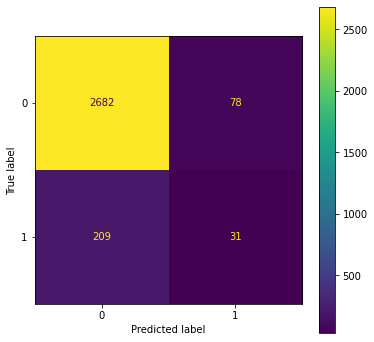

In [98]:
get_scores(f"{model_name} [w/thresholding]", **grd_knn, threshold=best_threshold, register=True, show_roccurves=False)

## 6. Review scores <a class="anchor" id="models_grid_scores"></a> [⇪](#menu)

In [99]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier,None,"{'random_state': [0], 'strategy': ['stratified']}",0.489674,0.078787,0.068966,0.838000,0.063830,0.075000,18,2496,264,222,1.208840,0.002087
1,Basic LogisticRegression,None,"{'random_state': [0], 'max_iter': [3000]}",0.745713,0.208292,0.000000,0.918667,0.000000,0.000000,0,2756,4,240,47.455576,0.024607
2,Basic LogisticRegression [w/thresholding],0.241,"{'random_state': [0], 'max_iter': [3000]}",0.745713,0.208292,0.209974,0.899667,0.283688,0.166667,40,2659,101,200,47.455576,0.004775
3,Basic DecisionTreeClassifier,None,{'random_state': [0]},0.530616,0.087217,0.138196,0.850333,0.128114,0.150000,36,2515,245,204,2.508329,0.010776
4,Basic DecisionTreeClassifier [w/thresholding],0.999,{'random_state': [0]},0.530616,0.087217,0.138196,0.850333,0.128114,0.150000,36,2515,245,204,2.508329,0.005019
5,Basic RandomForestClassifier,None,{'random_state': [0]},0.698664,0.177358,0.000000,0.920000,0.000000,0.000000,0,2760,0,240,2.883787,0.117337
6,Basic RandomForestClassifier [w/thresholding],0.68,{'random_state': [0]},0.698664,0.177358,0.000000,0.920000,0.000000,0.000000,0,2760,0,240,2.883787,0.069008
7,Basic XGBClassifier,None,"{'seed': [0], 'objective': ['binary:logistic']...",0.735420,0.200251,0.045455,0.916000,0.250000,0.025000,6,2742,18,234,8.793611,0.032197
8,Basic XGBClassifier [w/thresholding],0.561,"{'seed': [0], 'objective': ['binary:logistic']...",0.735420,0.200251,0.030888,0.916333,0.210526,0.016667,4,2745,15,236,8.793611,0.019872
9,Basic KNeighborsClassifier,None,{},0.580269,0.101572,0.029740,0.913000,0.137931,0.016667,4,2735,25,236,0.232196,4.742763


In [100]:
scores_df[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('Recall', ascending=False)

,Method,ROC AUC,F1 score,Recall
12,Grid LogisticRegression [w/thresholding],0.744284,0.225131,0.179167
2,Basic LogisticRegression [w/thresholding],0.745713,0.209974,0.166667
14,Grid DecisionTreeClassifier [w/thresholding],0.674401,0.177677,0.162500
3,Basic DecisionTreeClassifier,0.530616,0.138196,0.150000
4,Basic DecisionTreeClassifier [w/thresholding],0.530616,0.138196,0.150000
18,Grid XGBClassifier [w/thresholding],0.730993,0.193182,0.141667
10,Basic KNeighborsClassifier [w/thresholding],0.580269,0.145199,0.129167
20,Grid KNeighborsClassifier [w/thresholding],0.608801,0.177650,0.129167
0,DummyClassifier,0.489674,0.068966,0.075000
7,Basic XGBClassifier,0.735420,0.045455,0.025000


In [101]:
sms.send("Gridsearch done", stop=False)

# Impoving the models with `class_weight` for Imbalanced datasets <a class="anchor" id="models_balanced"></a> [⇪](#menu)

## 1. Logistic Regression balanced with `class_weight` + Grid search<a class="anchor" id="models_linear_balanced"></a> [⇪](#menu)

In [102]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [103]:
model_name = "Balanced LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5248
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7335
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5301
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6741
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6138

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6153 (std:0.0978)

----------------------------------------------------------------------------------------------------


In [104]:
grd_log['grid'].best_params_

{'C': 0.01,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs'}

--- Balanced LogisticRegression ---

             ROC_AUC : 0.7451
                  F1 : 0.2533
            ACCURACY : 0.6797
           PRECISION : 0.1557
              RECALL : 0.6792
   AVERAGE_PRECISION : 0.2162

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.80      2760
Prediction = 1       0.16      0.68      0.25       240

      accuracy                           0.68      3000
     macro avg       0.56      0.68      0.52      3000
  weighted avg       0.90      0.68      0.75      3000

--- Confusion Matrix ---



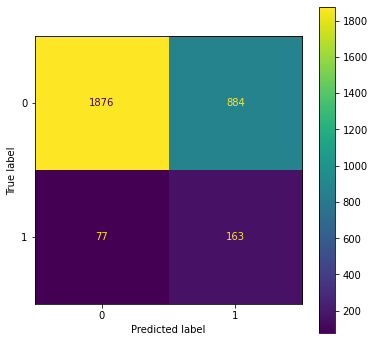

--- ROC AUC ---



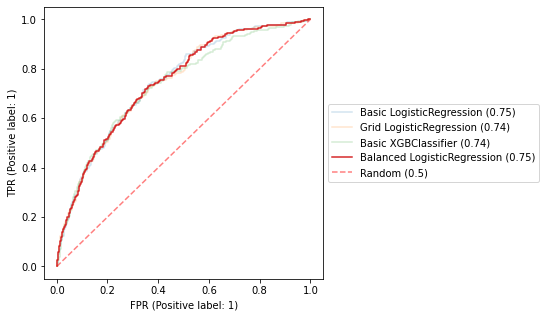

--- PRECISION RECALL AUC ---



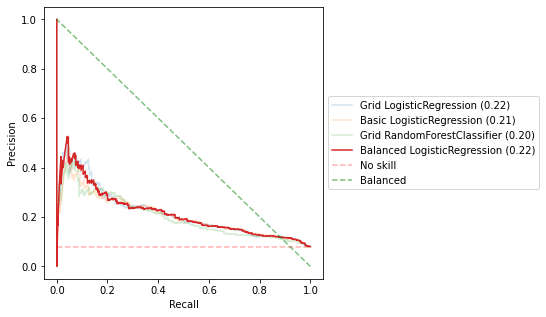

In [105]:
get_scores(model_name, **grd_log, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [106]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.20803080308030802) for this model is reached with a threshold of 0.354


--- Balanced LogisticRegression [w/thresholding] ---

             ROC_AUC : 0.7451
                  F1 : 0.2071
            ACCURACY : 0.4563
           PRECISION : 0.1172
              RECALL : 0.8875
   AVERAGE_PRECISION : 0.2162

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.98      0.42      0.59      2760
Prediction = 1       0.12      0.89      0.21       240

      accuracy                           0.46      3000
     macro avg       0.55      0.65      0.40      3000
  weighted avg       0.91      0.46      0.56      3000

--- Confusion Matrix ---



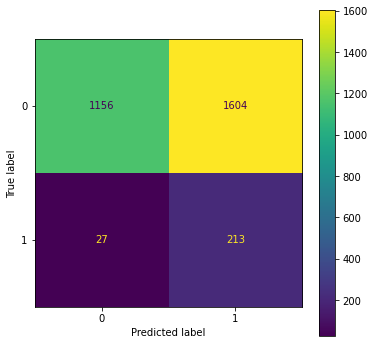

In [107]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 2. Decision Tree balanced with `class_weight` + Grid search <a class="anchor" id="models_decision_tree_balanced"></a> [⇪](#menu)

In [108]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [109]:
model_name = "Balanced DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5720
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5407
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5374
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6009
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5563

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5615 (std:0.0569)

----------------------------------------------------------------------------------------------------


In [110]:
grd_dt['grid'].best_params_

{'ccp_alpha': 0.001,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'random_state': 0}

--- Balanced DecisionTreeClassifier ---

             ROC_AUC : 0.6730
                  F1 : 0.2281
            ACCURACY : 0.6863
           PRECISION : 0.1420
              RECALL : 0.5792
   AVERAGE_PRECISION : 0.1360

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.70      0.80      2760
Prediction = 1       0.14      0.58      0.23       240

      accuracy                           0.69      3000
     macro avg       0.55      0.64      0.52      3000
  weighted avg       0.89      0.69      0.76      3000

--- Confusion Matrix ---



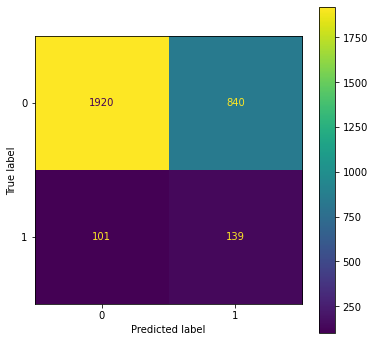

--- ROC AUC ---



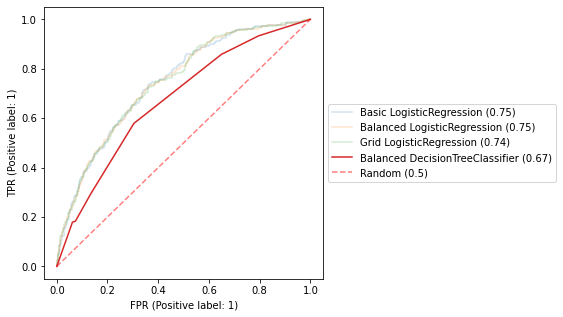

--- PRECISION RECALL AUC ---



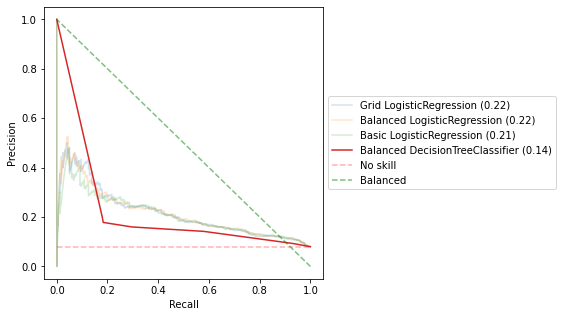

In [111]:
get_scores(model_name, **grd_dt, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [112]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.24494829712550992) for this model is reached with a threshold of 0.422


--- Balanced DecisionTreeClassifier [w/thresholding] ---

             ROC_AUC : 0.6730
                  F1 : 0.2281
            ACCURACY : 0.6863
           PRECISION : 0.1420
              RECALL : 0.5792
   AVERAGE_PRECISION : 0.1360

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.70      0.80      2760
Prediction = 1       0.14      0.58      0.23       240

      accuracy                           0.69      3000
     macro avg       0.55      0.64      0.52      3000
  weighted avg       0.89      0.69      0.76      3000

--- Confusion Matrix ---



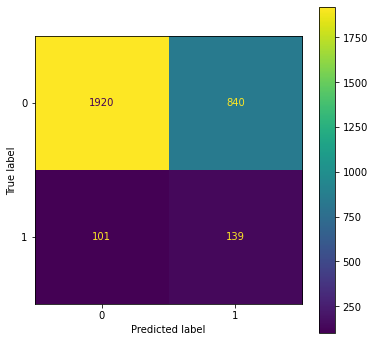

In [113]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Random Forest balanced with `class_weight` + Grid search<a class="anchor" id="models_random_forest_balanced"></a> [⇪](#menu)

In [114]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 528]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [115]:
model_name = "Balanced RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6620
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5527
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5799
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7571
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6112

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6326 (std:0.0776)

----------------------------------------------------------------------------------------------------


In [116]:
grd_rf['grid'].best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'n_estimators': 500,
 'random_state': 0}

--- Balanced RandomForestClassifier ---

             ROC_AUC : 0.7024
                  F1 : 0.2377
            ACCURACY : 0.6963
           PRECISION : 0.1487
              RECALL : 0.5917
   AVERAGE_PRECISION : 0.1942

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.71      0.81      2760
Prediction = 1       0.15      0.59      0.24       240

      accuracy                           0.70      3000
     macro avg       0.55      0.65      0.52      3000
  weighted avg       0.89      0.70      0.76      3000

--- Confusion Matrix ---



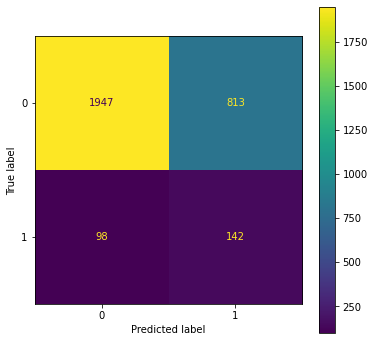

--- ROC AUC ---



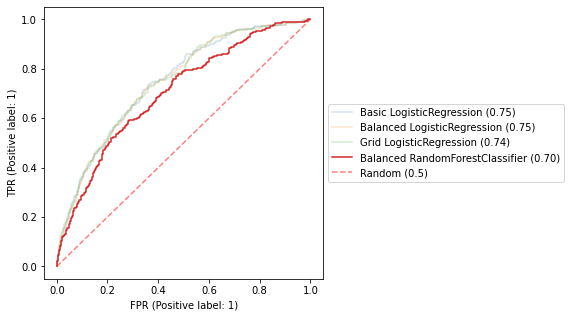

--- PRECISION RECALL AUC ---



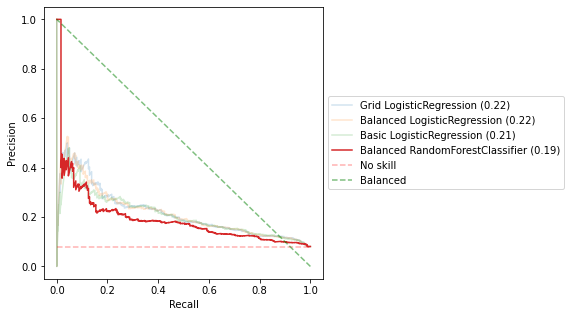

In [117]:
get_scores(model_name, **grd_rf, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [118]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.25132631245545967) for this model is reached with a threshold of 0.454


--- Balanced RandomForestClassifier [w/thresholding] ---

             ROC_AUC : 0.7024
                  F1 : 0.2192
            ACCURACY : 0.6223
           PRECISION : 0.1313
              RECALL : 0.6625
   AVERAGE_PRECISION : 0.1942

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.62      0.75      2760
Prediction = 1       0.13      0.66      0.22       240

      accuracy                           0.62      3000
     macro avg       0.54      0.64      0.49      3000
  weighted avg       0.89      0.62      0.71      3000

--- Confusion Matrix ---



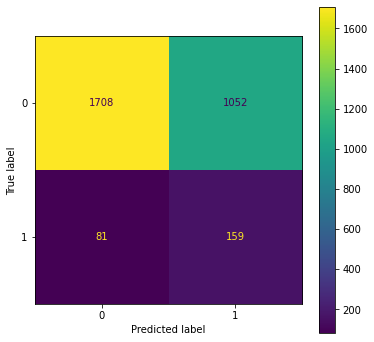

In [119]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 4. XGBoost Classifier balanced with `class_weight` + Grid search<a class="anchor" id="models_xgboost_balanced"></a> [⇪](#menu)

In [120]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [121]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [122]:
model_name = "Balanced XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6177
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5696
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7223
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.8023
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7295

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6883 (std:0.0947)

----------------------------------------------------------------------------------------------------


In [123]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 60,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.482662968099861,
 'seed': 0}

--- Balanced XGBClassifier ---

             ROC_AUC : 0.7207
                  F1 : 0.2378
            ACCURACY : 0.6730
           PRECISION : 0.1461
              RECALL : 0.6375
   AVERAGE_PRECISION : 0.1998

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      2760
Prediction = 1       0.15      0.64      0.24       240

      accuracy                           0.67      3000
     macro avg       0.55      0.66      0.51      3000
  weighted avg       0.89      0.67      0.75      3000

--- Confusion Matrix ---



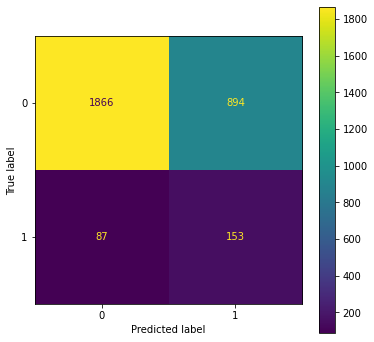

--- ROC AUC ---



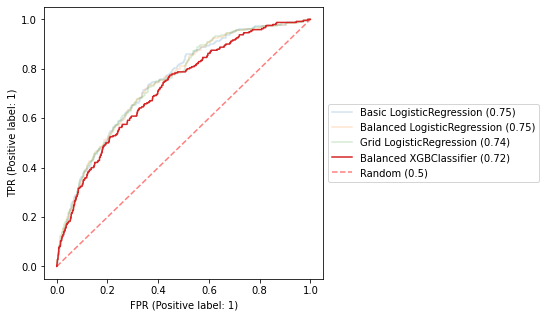

--- PRECISION RECALL AUC ---



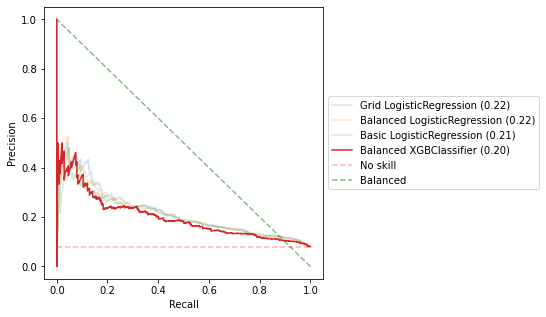

In [124]:
get_scores(model_name, **grd_xgb, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [125]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.19516207063376875) for this model is reached with a threshold of 0.352


--- Balanced XGBClassifier [w/thresholding] ---

             ROC_AUC : 0.7207
                  F1 : 0.1860
            ACCURACY : 0.3700
           PRECISION : 0.1037
              RECALL : 0.9000
   AVERAGE_PRECISION : 0.1998

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.32      0.49      2760
Prediction = 1       0.10      0.90      0.19       240

      accuracy                           0.37      3000
     macro avg       0.54      0.61      0.34      3000
  weighted avg       0.90      0.37      0.46      3000

--- Confusion Matrix ---



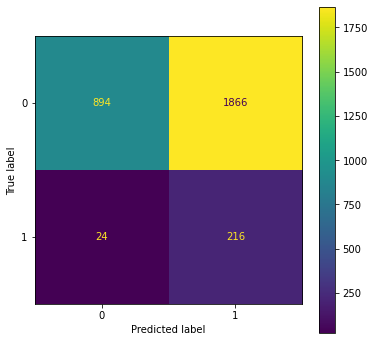

In [126]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 5. Review scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [127]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier,None,"{'random_state': [0], 'strategy': ['stratified']}",0.489674,0.078787,0.068966,0.838000,0.063830,0.075000,18,2496,264,222,1.208840,0.002087
1,Basic LogisticRegression,None,"{'random_state': [0], 'max_iter': [3000]}",0.745713,0.208292,0.000000,0.918667,0.000000,0.000000,0,2756,4,240,47.455576,0.024607
2,Basic LogisticRegression [w/thresholding],0.241,"{'random_state': [0], 'max_iter': [3000]}",0.745713,0.208292,0.209974,0.899667,0.283688,0.166667,40,2659,101,200,47.455576,0.004775
3,Basic DecisionTreeClassifier,None,{'random_state': [0]},0.530616,0.087217,0.138196,0.850333,0.128114,0.150000,36,2515,245,204,2.508329,0.010776
4,Basic DecisionTreeClassifier [w/thresholding],0.999,{'random_state': [0]},0.530616,0.087217,0.138196,0.850333,0.128114,0.150000,36,2515,245,204,2.508329,0.005019
5,Basic RandomForestClassifier,None,{'random_state': [0]},0.698664,0.177358,0.000000,0.920000,0.000000,0.000000,0,2760,0,240,2.883787,0.117337
6,Basic RandomForestClassifier [w/thresholding],0.68,{'random_state': [0]},0.698664,0.177358,0.000000,0.920000,0.000000,0.000000,0,2760,0,240,2.883787,0.069008
7,Basic XGBClassifier,None,"{'seed': [0], 'objective': ['binary:logistic']...",0.735420,0.200251,0.045455,0.916000,0.250000,0.025000,6,2742,18,234,8.793611,0.032197
8,Basic XGBClassifier [w/thresholding],0.561,"{'seed': [0], 'objective': ['binary:logistic']...",0.735420,0.200251,0.030888,0.916333,0.210526,0.016667,4,2745,15,236,8.793611,0.019872
9,Basic KNeighborsClassifier,None,{},0.580269,0.101572,0.029740,0.913000,0.137931,0.016667,4,2735,25,236,0.232196,4.742763


In [128]:
scores_df[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('ROC AUC', ascending=False)

,Method,ROC AUC,F1 score,Recall
2,Basic LogisticRegression [w/thresholding],0.745713,0.209974,0.166667
1,Basic LogisticRegression,0.745713,0.000000,0.000000
21,Balanced LogisticRegression,0.745054,0.253302,0.679167
22,Balanced LogisticRegression [w/thresholding],0.745054,0.207098,0.887500
12,Grid LogisticRegression [w/thresholding],0.744284,0.225131,0.179167
11,Grid LogisticRegression,0.744284,0.000000,0.000000
7,Basic XGBClassifier,0.735420,0.045455,0.025000
8,Basic XGBClassifier [w/thresholding],0.735420,0.030888,0.016667
17,Grid XGBClassifier,0.730993,0.000000,0.000000
18,Grid XGBClassifier [w/thresholding],0.730993,0.193182,0.141667


In [129]:
sms.send("Balanced done", stop=False)

# Impoving the models with SMOT for Imbalanced datasets <a class="anchor" id="models_balanced_smot"></a> [⇪](#menu)

In [179]:
from imblearn.over_sampling import SMOTE

In [180]:
#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_x_train, over_y_train = oversample.fit_resample(X_train,y_train)

In [181]:
over_y_train.value_counts()

0    24837
1    24837
Name: TARGET, dtype: int64

In [191]:
y_test.value_counts()

0    2760
1     240
Name: TARGET, dtype: int64

## 1. Logistic Regression balanced with `SMOT` + Grid search<a class="anchor" id="models_linear_smot"></a> [⇪](#menu)

In [183]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [185]:
model_name = "SMOT LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7192
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6690
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6466
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7148
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7297

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6959 (std:0.0414)

----------------------------------------------------------------------------------------------------


In [186]:
grd_log['grid'].best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear'}

--- SMOT LogisticRegression ---

             ROC_AUC : 0.7420
                  F1 : 0.2454
            ACCURACY : 0.6863
           PRECISION : 0.1519
              RECALL : 0.6375
   AVERAGE_PRECISION : 0.2001

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.69      0.80      2760
Prediction = 1       0.15      0.64      0.25       240

      accuracy                           0.69      3000
     macro avg       0.55      0.66      0.52      3000
  weighted avg       0.89      0.69      0.76      3000

--- Confusion Matrix ---



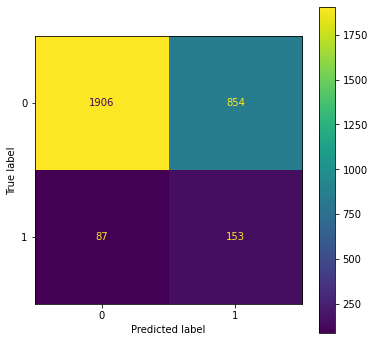

--- ROC AUC ---



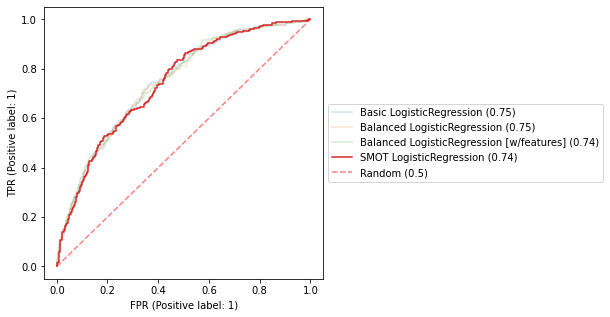

--- PRECISION RECALL AUC ---



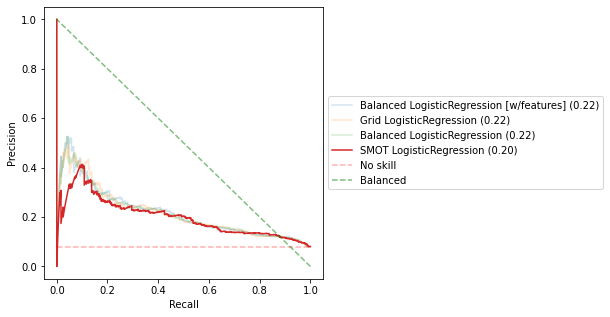

In [187]:
get_scores(model_name, **grd_log, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [188]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.23012920246228774) for this model is reached with a threshold of 0.388


--- SMOT LogisticRegression [w/thresholding] ---

             ROC_AUC : 0.7420
                  F1 : 0.2284
            ACCURACY : 0.5677
           PRECISION : 0.1332
              RECALL : 0.8000
   AVERAGE_PRECISION : 0.2001

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.55      0.70      2760
Prediction = 1       0.13      0.80      0.23       240

      accuracy                           0.57      3000
     macro avg       0.55      0.67      0.46      3000
  weighted avg       0.90      0.57      0.66      3000

--- Confusion Matrix ---



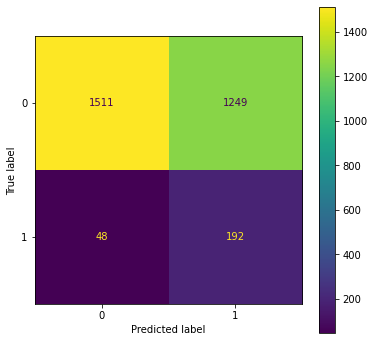

In [189]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 2. Decision Tree balanced with `SMOT` + Grid search <a class="anchor" id="models_decision_tree_smot"></a> [⇪](#menu)

In [193]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [194]:
model_name = "SMOT DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6738
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7157
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6872
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6741
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6940

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6890 (std:0.0367)

----------------------------------------------------------------------------------------------------


In [195]:
grd_dt['grid'].best_params_

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 9,
 'max_features': None,
 'random_state': 0}

--- SMOT DecisionTreeClassifier ---

             ROC_AUC : 0.6249
                  F1 : 0.1800
            ACCURACY : 0.8117
           PRECISION : 0.1381
              RECALL : 0.2583
   AVERAGE_PRECISION : 0.1148

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.86      0.89      2760
Prediction = 1       0.14      0.26      0.18       240

      accuracy                           0.81      3000
     macro avg       0.53      0.56      0.54      3000
  weighted avg       0.87      0.81      0.84      3000

--- Confusion Matrix ---



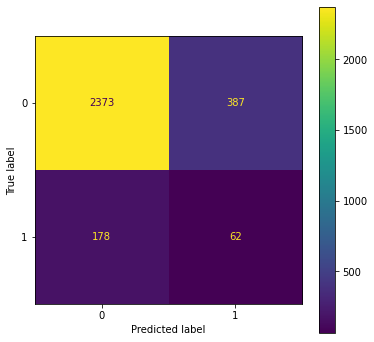

--- ROC AUC ---



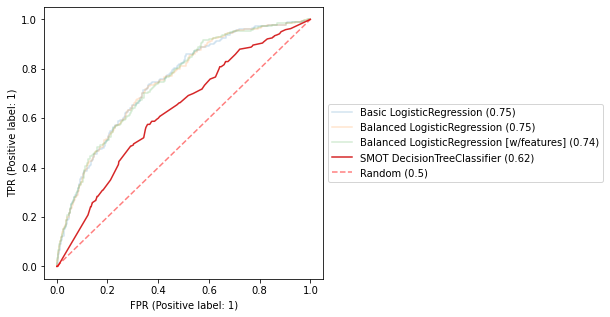

--- PRECISION RECALL AUC ---



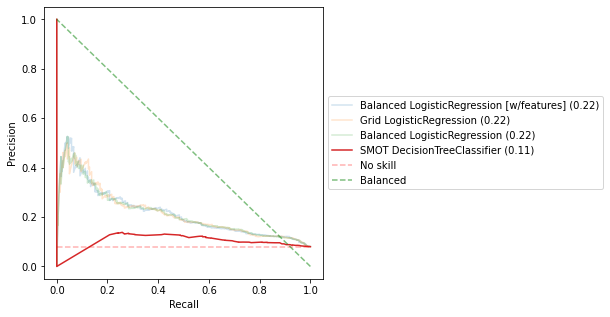

In [196]:
get_scores(model_name, **grd_dt, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [197]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.24138583869746305) for this model is reached with a threshold of 0.28500000000000003


--- SMOT DecisionTreeClassifier [w/thresholding] ---

             ROC_AUC : 0.6249
                  F1 : 0.1993
            ACCURACY : 0.6813
           PRECISION : 0.1247
              RECALL : 0.4958
   AVERAGE_PRECISION : 0.1148

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.94      0.70      0.80      2760
Prediction = 1       0.12      0.50      0.20       240

      accuracy                           0.68      3000
     macro avg       0.53      0.60      0.50      3000
  weighted avg       0.88      0.68      0.75      3000

--- Confusion Matrix ---



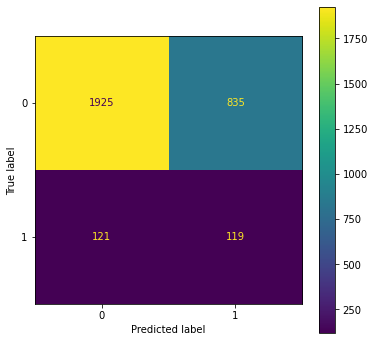

In [198]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Random Forest balanced with `SMOT` + Grid search<a class="anchor" id="models_random_forest_smot"></a> [⇪](#menu)

In [199]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 528]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [200]:
model_name = "SMOT RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.9125
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.9245
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.9322
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.9267
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.8878

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.9167 (std:0.0204)

----------------------------------------------------------------------------------------------------


In [201]:
grd_rf['grid'].best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'n_estimators': 500,
 'random_state': 0}

--- SMOT RandomForestClassifier ---

             ROC_AUC : 0.7108
                  F1 : 0.0000
            ACCURACY : 0.9193
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1639

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.00      0.00      0.00       240

      accuracy                           0.92      3000
     macro avg       0.46      0.50      0.48      3000
  weighted avg       0.85      0.92      0.88      3000

--- Confusion Matrix ---



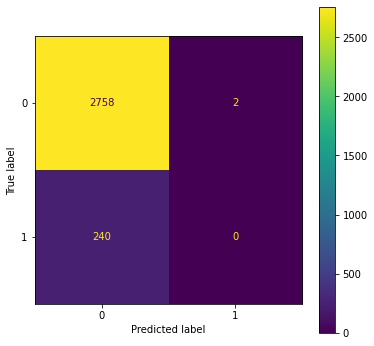

--- ROC AUC ---



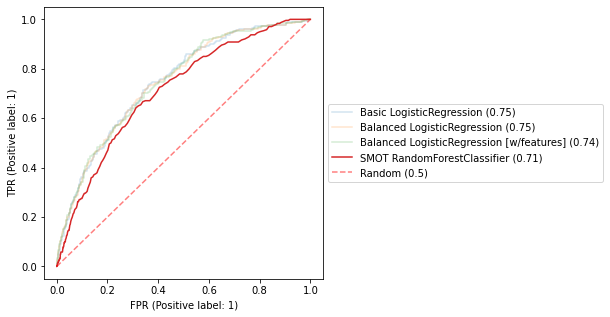

--- PRECISION RECALL AUC ---



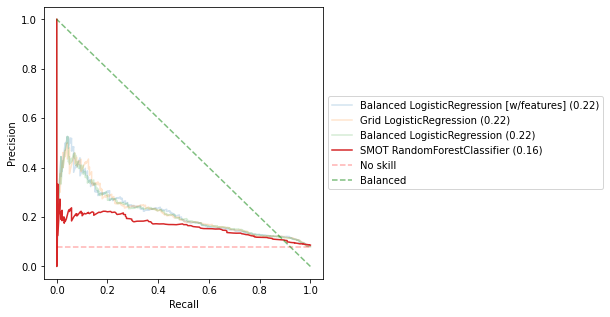

In [202]:
get_scores(model_name, **grd_rf, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [203]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.7565392354124749) for this model is reached with a threshold of 0.746


--- SMOT RandomForestClassifier [w/thresholding] ---

             ROC_AUC : 0.7108
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1639

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.00      0.00      0.00       240

      accuracy                           0.92      3000
     macro avg       0.46      0.50      0.48      3000
  weighted avg       0.85      0.92      0.88      3000

--- Confusion Matrix ---



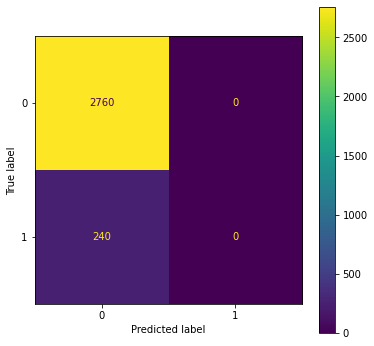

In [204]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 4. XGBoost Classifier balanced with `SMOT` + Grid search<a class="anchor" id="models_xgboost_smot"></a> [⇪](#menu)

In [205]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [206]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [207]:
model_name = "SMOT XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.8905
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.9301
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.9195
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.9345
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.9333

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.9216 (std:0.0206)

----------------------------------------------------------------------------------------------------


In [208]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.1,
 'max_depth': 9,
 'n_estimators': 180,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.482662968099861,
 'seed': 0}

--- SMOT XGBClassifier ---

             ROC_AUC : 0.6968
                  F1 : 0.2274
            ACCURACY : 0.8777
           PRECISION : 0.2298
              RECALL : 0.2250
   AVERAGE_PRECISION : 0.1752

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.93      0.93      2760
Prediction = 1       0.23      0.23      0.23       240

      accuracy                           0.88      3000
     macro avg       0.58      0.58      0.58      3000
  weighted avg       0.88      0.88      0.88      3000

--- Confusion Matrix ---



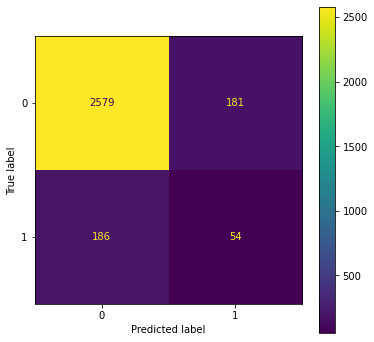

--- ROC AUC ---



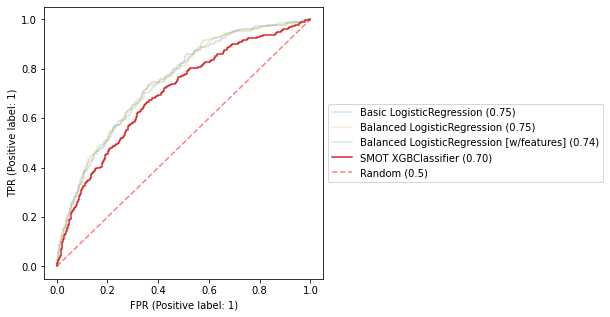

--- PRECISION RECALL AUC ---



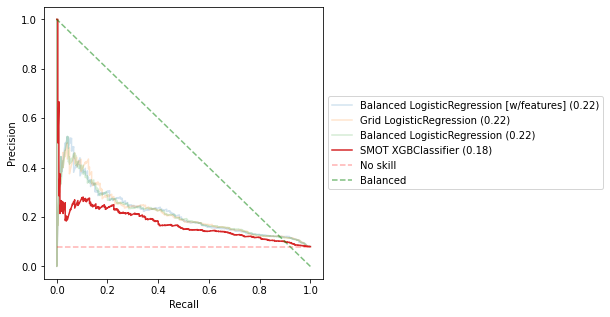

In [209]:
get_scores(model_name, **grd_xgb, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [210]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.8746097814776275) for this model is reached with a threshold of 0.875


--- SMOT XGBClassifier [w/thresholding] ---

             ROC_AUC : 0.6968
                  F1 : 0.0240
            ACCURACY : 0.9187
           PRECISION : 0.3000
              RECALL : 0.0125
   AVERAGE_PRECISION : 0.1752

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.30      0.01      0.02       240

      accuracy                           0.92      3000
     macro avg       0.61      0.50      0.49      3000
  weighted avg       0.87      0.92      0.88      3000

--- Confusion Matrix ---



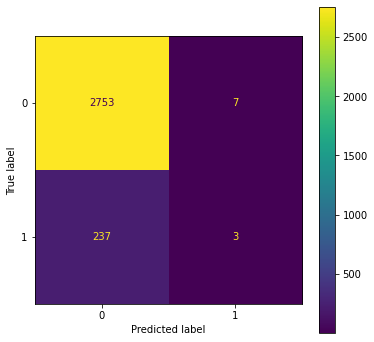

In [211]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 5. KNN *(k-nearest neighbors)* Grid <a class="anchor" id="models_knn_grid"></a> [⇪](#menu)

In [212]:
param_grid = {
    'n_neighbors': list(range(1,35,2)), # tous les chiffres impairs de 1 à 33 inclus
    #'weight_options': ['uniform', 'distance']
}

In [213]:
model_name = "SMOT KNeighborsClassifier"

grd_knn = fit_model(
    model_name,
    KNeighborsClassifier(n_jobs=-1), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6616
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6253
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6103
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6309
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6222

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6301 (std:0.0316)

----------------------------------------------------------------------------------------------------


--- SMOT KNeighborsClassifier ---

             ROC_AUC : 0.5867
                  F1 : 0.1640
            ACCURACY : 0.4493
           PRECISION : 0.0933
              RECALL : 0.6750
   AVERAGE_PRECISION : 0.1055

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.94      0.43      0.59      2760
Prediction = 1       0.09      0.68      0.16       240

      accuracy                           0.45      3000
     macro avg       0.52      0.55      0.38      3000
  weighted avg       0.87      0.45      0.56      3000

--- Confusion Matrix ---



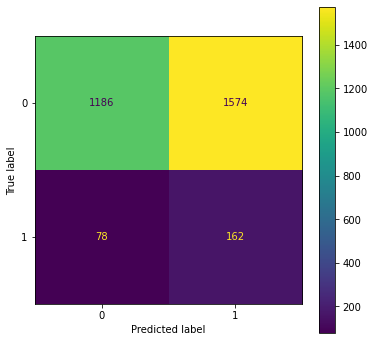

--- ROC AUC ---



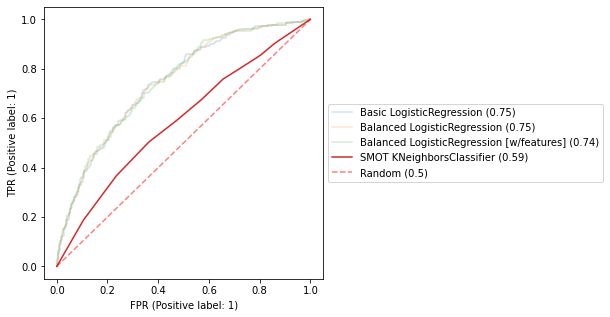

--- PRECISION RECALL AUC ---



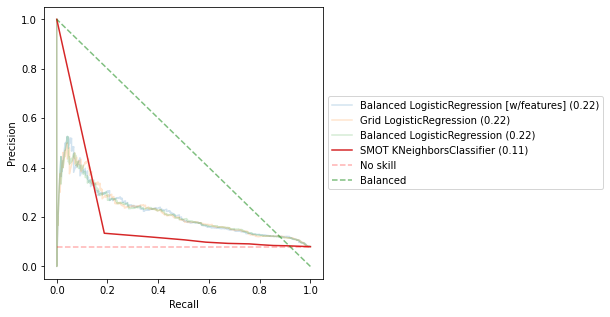

In [214]:
get_scores(model_name, **grd_knn, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [215]:
f1_value, best_threshold = find_best_threshold(grd_knn['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.9489795918367347) for this model is reached with a threshold of 0.9490000000000001


--- SMOT KNeighborsClassifier [w/thresholding] ---

             ROC_AUC : 0.5867
                  F1 : 0.1565
            ACCURACY : 0.8383
           PRECISION : 0.1343
              RECALL : 0.1875
   AVERAGE_PRECISION : 0.1055

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.89      0.91      2760
Prediction = 1       0.13      0.19      0.16       240

      accuracy                           0.84      3000
     macro avg       0.53      0.54      0.53      3000
  weighted avg       0.86      0.84      0.85      3000

--- Confusion Matrix ---



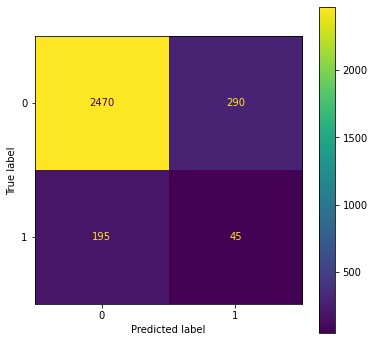

In [216]:
get_scores(f"{model_name} [w/thresholding]", **grd_knn, threshold=best_threshold, register=True, show_roccurves=False)

## 6. Review scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [127]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier,None,"{'random_state': [0], 'strategy': ['stratified']}",0.489674,0.078787,0.068966,0.838000,0.063830,0.075000,18,2496,264,222,1.208840,0.002087
1,Basic LogisticRegression,None,"{'random_state': [0], 'max_iter': [3000]}",0.745713,0.208292,0.000000,0.918667,0.000000,0.000000,0,2756,4,240,47.455576,0.024607
2,Basic LogisticRegression [w/thresholding],0.241,"{'random_state': [0], 'max_iter': [3000]}",0.745713,0.208292,0.209974,0.899667,0.283688,0.166667,40,2659,101,200,47.455576,0.004775
3,Basic DecisionTreeClassifier,None,{'random_state': [0]},0.530616,0.087217,0.138196,0.850333,0.128114,0.150000,36,2515,245,204,2.508329,0.010776
4,Basic DecisionTreeClassifier [w/thresholding],0.999,{'random_state': [0]},0.530616,0.087217,0.138196,0.850333,0.128114,0.150000,36,2515,245,204,2.508329,0.005019
5,Basic RandomForestClassifier,None,{'random_state': [0]},0.698664,0.177358,0.000000,0.920000,0.000000,0.000000,0,2760,0,240,2.883787,0.117337
6,Basic RandomForestClassifier [w/thresholding],0.68,{'random_state': [0]},0.698664,0.177358,0.000000,0.920000,0.000000,0.000000,0,2760,0,240,2.883787,0.069008
7,Basic XGBClassifier,None,"{'seed': [0], 'objective': ['binary:logistic']...",0.735420,0.200251,0.045455,0.916000,0.250000,0.025000,6,2742,18,234,8.793611,0.032197
8,Basic XGBClassifier [w/thresholding],0.561,"{'seed': [0], 'objective': ['binary:logistic']...",0.735420,0.200251,0.030888,0.916333,0.210526,0.016667,4,2745,15,236,8.793611,0.019872
9,Basic KNeighborsClassifier,None,{},0.580269,0.101572,0.029740,0.913000,0.137931,0.016667,4,2735,25,236,0.232196,4.742763


In [128]:
scores_df[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('ROC AUC', ascending=False)

,Method,ROC AUC,F1 score,Recall
2,Basic LogisticRegression [w/thresholding],0.745713,0.209974,0.166667
1,Basic LogisticRegression,0.745713,0.000000,0.000000
21,Balanced LogisticRegression,0.745054,0.253302,0.679167
22,Balanced LogisticRegression [w/thresholding],0.745054,0.207098,0.887500
12,Grid LogisticRegression [w/thresholding],0.744284,0.225131,0.179167
11,Grid LogisticRegression,0.744284,0.000000,0.000000
7,Basic XGBClassifier,0.735420,0.045455,0.025000
8,Basic XGBClassifier [w/thresholding],0.735420,0.030888,0.016667
17,Grid XGBClassifier,0.730993,0.000000,0.000000
18,Grid XGBClassifier [w/thresholding],0.730993,0.193182,0.141667


# Impoving the models with extra Features <a class="anchor" id="models_feature_engineering"></a> [⇪](#menu)

In [130]:
data_application_full = pd.read_csv(
    zip_file.open('application_train.csv'),
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

data_application_full.shape

(307511, 122)

## Feature Engineering <a class="anchor" id="feature_engineering"></a> [⇪](#menu)

### What fraction of the price of the goods for which the loan is given, represent the credit amount?

In [131]:
data_application_full['FRAC_GOODS_PRICE'] = data_application_full.AMT_CREDIT / data_application_full.AMT_GOODS_PRICE

In [132]:
data_application_full[['AMT_CREDIT','AMT_GOODS_PRICE','FRAC_GOODS_PRICE']].head()

,AMT_CREDIT,AMT_GOODS_PRICE,FRAC_GOODS_PRICE
0,406597.5,351000.0,1.158397
1,1293502.5,1129500.0,1.145199
2,135000.0,135000.0,1.000000
3,312682.5,297000.0,1.052803
4,513000.0,513000.0,1.000000


### How old was the client when it started his current employement position?

In [133]:
data_application_full['AGE_EMPLOYEMENT'] = (data_application_full.DAYS_BIRTH - data_application_full.DAYS_EMPLOYED) / -365

In [134]:
data_application_full[['DAYS_BIRTH','DAYS_EMPLOYED','AGE_EMPLOYEMENT']].head()

,DAYS_BIRTH,DAYS_EMPLOYED,AGE_EMPLOYEMENT
0,-9461,-637,24.175342
1,-16765,-1188,42.676712
2,-19046,-225,51.564384
3,-19005,-3039,43.742466
4,-19932,-3038,46.284932


### What fraction of the total incomes per member of the family?

In [135]:
data_application_full['INCOME_PER_FAM_MEMBER'] = data_application_full.AMT_INCOME_TOTAL / data_application_full.CNT_FAM_MEMBERS

In [136]:
data_application_full[['AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','INCOME_PER_FAM_MEMBER']].head()

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,INCOME_PER_FAM_MEMBER
0,202500.0,1.0,202500.0
1,270000.0,2.0,135000.0
2,67500.0,1.0,67500.0
3,135000.0,2.0,67500.0
4,121500.0,1.0,121500.0


### How many requests overall have been made to the credit bureau?

In [137]:
data_application_full['AMT_REQ_CREDIT_BUREAU_TOTAL'] =  data_application_full.AMT_REQ_CREDIT_BUREAU_HOUR +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_DAY +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_WEEK +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_MON +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_QRT +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_YEAR

In [138]:
data_application_full[['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','AMT_REQ_CREDIT_BUREAU_TOTAL']].head()

,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_TOTAL
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
data_application_train2 = data_application_train.copy()

In [140]:
data_application_train2['FRAC_GOODS_PRICE'] = data_application_full['FRAC_GOODS_PRICE']
data_application_train2['AGE_EMPLOYEMENT'] = data_application_full['AGE_EMPLOYEMENT']
data_application_train2['INCOME_PER_FAM_MEMBER'] = data_application_full['INCOME_PER_FAM_MEMBER']
data_application_train2['AMT_REQ_CREDIT_BUREAU_TOTAL'] = data_application_full['AMT_REQ_CREDIT_BUREAU_TOTAL']

In [141]:
correlations = data_application_train2.corr(method='pearson')

#### ---- Let's check for the top correlations with the `TARGET` variable ----

In [142]:
view_size = 100
threshold = 0.0
corr_target = correlations.TARGET.sort_values(ascending=False)
print(f"{f'TOP POSITIVES > {threshold}'.rjust(40)}          {f'TOP NEGATIVES < -{threshold}'.rjust(40)}\n{'-'*100}")
for i, row in enumerate(zip(
    corr_target.head(view_size).index, corr_target.head(view_size), 
    reversed(corr_target.tail(view_size).index), reversed(corr_target.tail(view_size)))):
    
    print(f"{row[0].rjust(40)} : {row[1]:6.4f} {row[2].rjust(40)} : {row[3]:6.4f}")
    if((row[1] < threshold and row[3] > -threshold) or (i>=len(corr_target)//2)):
        break

                     TOP POSITIVES > 0.0                              TOP NEGATIVES < -0.0
----------------------------------------------------------------------------------------------------
                                  TARGET : 1.0000                             EXT_SOURCE_3 : -0.1789
                              DAYS_BIRTH : 0.0782                             EXT_SOURCE_2 : -0.1605
                        FRAC_GOODS_PRICE : 0.0694                             EXT_SOURCE_1 : -0.1553
             REGION_RATING_CLIENT_W_CITY : 0.0609                          AGE_EMPLOYEMENT : -0.0465
                    REGION_RATING_CLIENT : 0.0589                            DAYS_EMPLOYED : -0.0449
                  DAYS_LAST_PHONE_CHANGE : 0.0552                            FLOORSMAX_AVG : -0.0440
                         DAYS_ID_PUBLISH : 0.0515                           FLOORSMAX_MEDI : -0.0438
                  REG_CITY_NOT_WORK_CITY : 0.0510                           FLOORSMAX_MODE : -0.0432


In [143]:
data_clean = data_application_train2[:sample_size_base].copy()

In [144]:
X_full = data_clean.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_clean['TARGET']

In [145]:
#X_train_full, X_test, y_train_full, y_test = train_test_split(
X_train, X_test, y_train, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.10,
                                                random_state=0,
                                                stratify=Y_full)

### Encoding the qualitative variables

In [146]:
#oe_targets = [x for x in X_train_full.select_dtypes(exclude='number').columns if X_train_full[x].nunique() == 2]
#ohe_targets = [x for x in X_train_full.select_dtypes(exclude='number').columns if X_train_full[x].nunique() > 2]

oe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() == 2]
ohe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() > 2]

#### Fit the encoders

In [147]:
oe_model, ohe_model = fit_labels(X_train)

#### Transform the `training`, `validation` and `testing` sets

In [148]:
#X_train_full = transform_labels(X_train_full, oe_model, ohe_model)
X_train = transform_labels(X_train, oe_model, ohe_model)
#X_valid = transform_labels(X_valid, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)

### Imputations

In [149]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

In [150]:
#X_train_full = impute(X_train_full, imputer_model)
X_train = impute(X_train, imputer_model)
#X_valid = impute(X_valid, imputer_model)
X_test = impute(X_test, imputer_model)

(27000, 246) <class 'pandas.core.frame.DataFrame'>
(3000, 246) <class 'pandas.core.frame.DataFrame'>


### Normalizing the dataset

In [151]:
model_scaler = fit_normalizer(X_train)

In [152]:
#X_train_full = normalize(X_train_full, model_scaler)
X_train = normalize(X_train, model_scaler)
#X_valid = normalize(X_valid, model_scaler)
X_test = normalize(X_test, model_scaler)

## 1. Balanced Logistic Regression Grid + extra features<a class="anchor" id="models_linear_balanced_feature"></a> [⇪](#menu)

In [153]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [154]:
model_name = "Balanced LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5394
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5886
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5287
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5768
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5860

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5639 (std:0.0641)

----------------------------------------------------------------------------------------------------


In [155]:
grd_log['grid'].best_params_

{'C': 0.01,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear'}

--- Balanced LogisticRegression [w/features] ---

             ROC_AUC : 0.7449
                  F1 : 0.2484
            ACCURACY : 0.6793
           PRECISION : 0.1529
              RECALL : 0.6625
   AVERAGE_PRECISION : 0.2180

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.80      2760
Prediction = 1       0.15      0.66      0.25       240

      accuracy                           0.68      3000
     macro avg       0.56      0.67      0.52      3000
  weighted avg       0.89      0.68      0.75      3000

--- Confusion Matrix ---



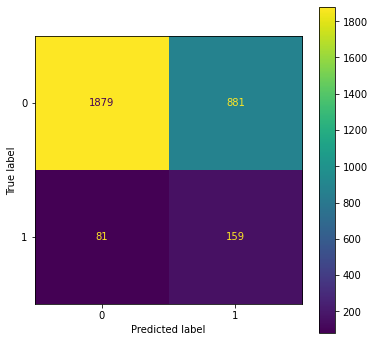

--- ROC AUC ---



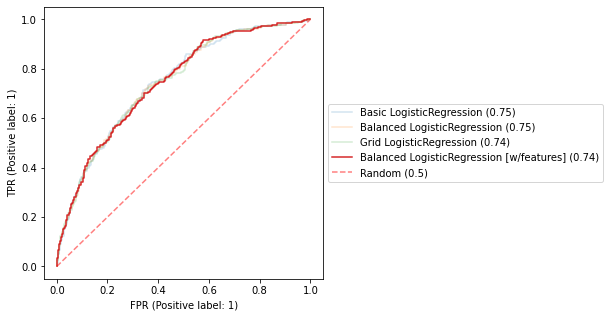

--- PRECISION RECALL AUC ---



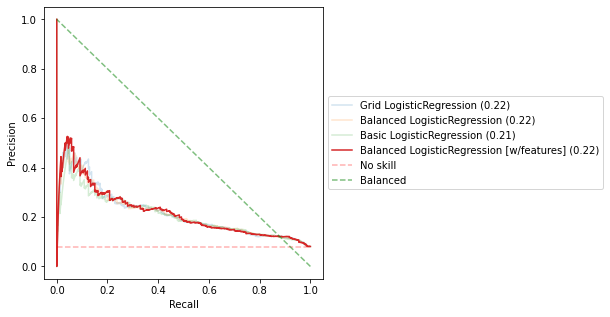

In [156]:
get_scores(f"{model_name} [w/features]", **grd_log, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [157]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.19701223180268698) for this model is reached with a threshold of 0.318


--- Balanced LogisticRegression [w/thresholding & features] ---

             ROC_AUC : 0.7449
                  F1 : 0.1998
            ACCURACY : 0.4047
           PRECISION : 0.1119
              RECALL : 0.9292
   AVERAGE_PRECISION : 0.2180

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.98      0.36      0.53      2760
Prediction = 1       0.11      0.93      0.20       240

      accuracy                           0.40      3000
     macro avg       0.55      0.64      0.36      3000
  weighted avg       0.91      0.40      0.50      3000

--- Confusion Matrix ---



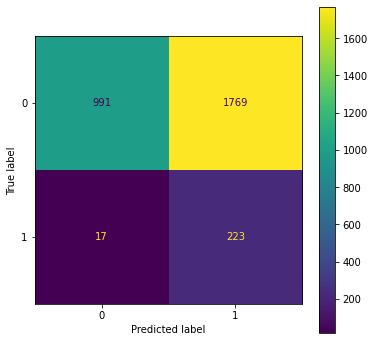

In [158]:
get_scores(f"{model_name} [w/thresholding & features]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 2. Balanced Decision Tree Grid + extra features<a class="anchor" id="models_decision_tree_balanced_feature"></a> [⇪](#menu)

In [159]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [160]:
model_name = "Balanced DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5537
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5837
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5519
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5247
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5872

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5602 (std:0.0549)

----------------------------------------------------------------------------------------------------


In [161]:
grd_dt['grid'].best_params_

{'ccp_alpha': 0.001,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None,
 'random_state': 0}

--- Balanced DecisionTreeClassifier [w/features] ---

             ROC_AUC : 0.6728
                  F1 : 0.2295
            ACCURACY : 0.6933
           PRECISION : 0.1436
              RECALL : 0.5708
   AVERAGE_PRECISION : 0.1369

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.70      0.81      2760
Prediction = 1       0.14      0.57      0.23       240

      accuracy                           0.69      3000
     macro avg       0.55      0.64      0.52      3000
  weighted avg       0.89      0.69      0.76      3000

--- Confusion Matrix ---



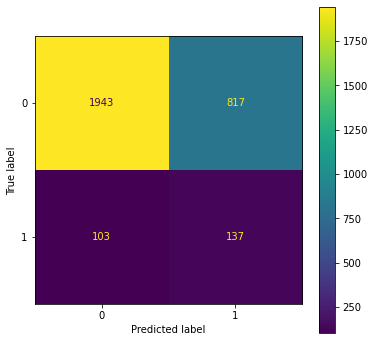

--- ROC AUC ---



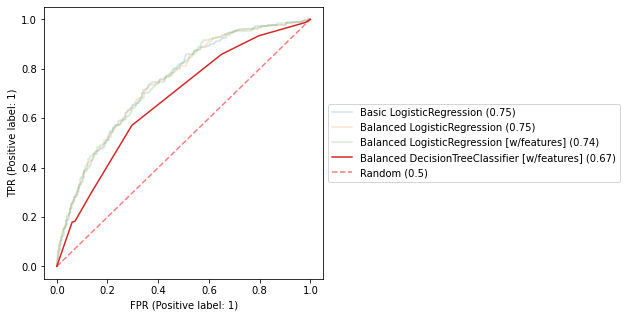

--- PRECISION RECALL AUC ---



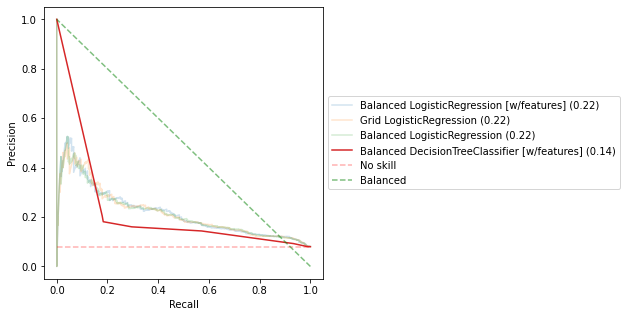

In [162]:
get_scores(f"{model_name} [w/features]", **grd_dt, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [163]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2457594448727833) for this model is reached with a threshold of 0.425


--- Balanced DecisionTreeClassifier [w/thresholding & features] ---

             ROC_AUC : 0.6728
                  F1 : 0.2295
            ACCURACY : 0.6933
           PRECISION : 0.1436
              RECALL : 0.5708
   AVERAGE_PRECISION : 0.1369

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.70      0.81      2760
Prediction = 1       0.14      0.57      0.23       240

      accuracy                           0.69      3000
     macro avg       0.55      0.64      0.52      3000
  weighted avg       0.89      0.69      0.76      3000

--- Confusion Matrix ---



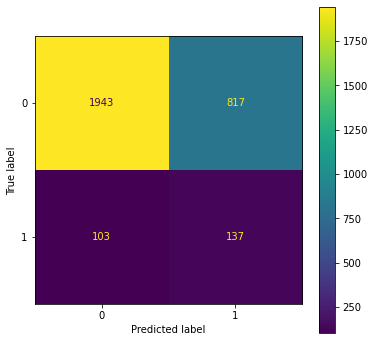

In [164]:
get_scores(f"{model_name} [w/thresholding & features]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Balanced Random Forest Grid + extra features <a class="anchor" id="models_random_forest_balanced_feature"></a> [⇪](#menu)

In [165]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 528]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [166]:
model_name = "Balanced RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6942
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5601
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6154
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6877
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5665

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6248 (std:0.0689)

----------------------------------------------------------------------------------------------------


In [167]:
grd_rf['grid'].best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'n_estimators': 400,
 'random_state': 0}

--- Balanced RandomForestClassifier [w/features] ---

             ROC_AUC : 0.6964
                  F1 : 0.2250
            ACCURACY : 0.6693
           PRECISION : 0.1385
              RECALL : 0.6000
   AVERAGE_PRECISION : 0.1860

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.68      0.79      2760
Prediction = 1       0.14      0.60      0.22       240

      accuracy                           0.67      3000
     macro avg       0.54      0.64      0.51      3000
  weighted avg       0.89      0.67      0.74      3000

--- Confusion Matrix ---



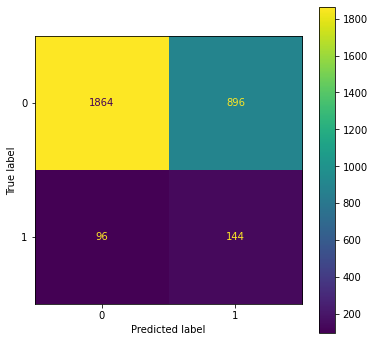

--- ROC AUC ---



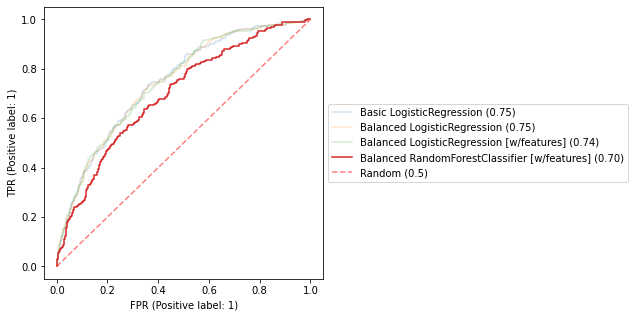

--- PRECISION RECALL AUC ---



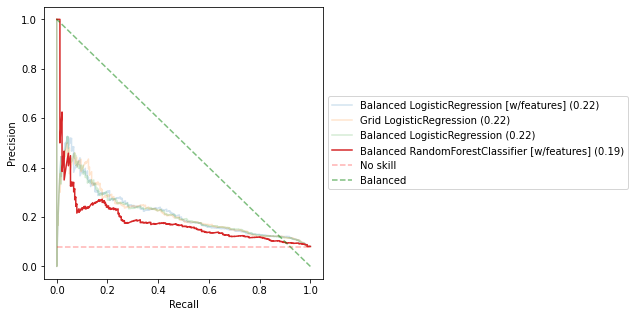

In [168]:
get_scores(f"{model_name} [w/features]", **grd_rf, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [169]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2238083099668621) for this model is reached with a threshold of 0.419


--- Balanced RandomForestClassifier [w/thresholding & features] ---

             ROC_AUC : 0.6964
                  F1 : 0.2036
            ACCURACY : 0.5253
           PRECISION : 0.1176
              RECALL : 0.7583
   AVERAGE_PRECISION : 0.1860

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.51      0.66      2760
Prediction = 1       0.12      0.76      0.20       240

      accuracy                           0.53      3000
     macro avg       0.54      0.63      0.43      3000
  weighted avg       0.89      0.53      0.63      3000

--- Confusion Matrix ---



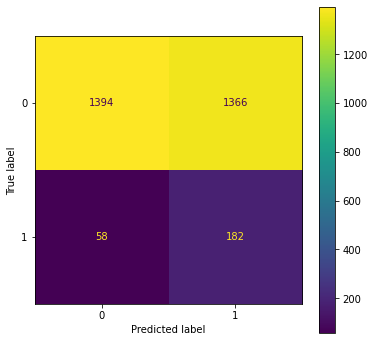

In [170]:
get_scores(f"{model_name} [w/thresholding & features]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 4. Balanced XGBoost Classifier Grid + extra features<a class="anchor" id="models_xgboost_balanced_feature"></a> [⇪](#menu)

In [171]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [172]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [173]:
model_name = "Balanced XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5329
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6251
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7377
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6719
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6780

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6491 (std:0.0867)

----------------------------------------------------------------------------------------------------


In [174]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 180,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.482662968099861,
 'seed': 0}

--- Balanced XGBClassifier [w/features] ---

             ROC_AUC : 0.7329
                  F1 : 0.2414
            ACCURACY : 0.6857
           PRECISION : 0.1496
              RECALL : 0.6250
   AVERAGE_PRECISION : 0.2084

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.69      0.80      2760
Prediction = 1       0.15      0.62      0.24       240

      accuracy                           0.69      3000
     macro avg       0.55      0.66      0.52      3000
  weighted avg       0.89      0.69      0.76      3000

--- Confusion Matrix ---



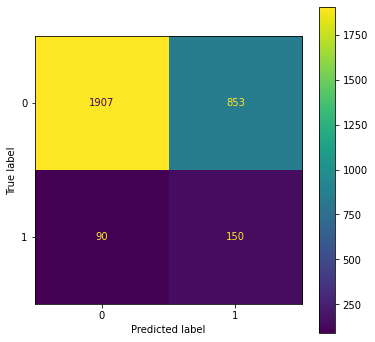

--- ROC AUC ---



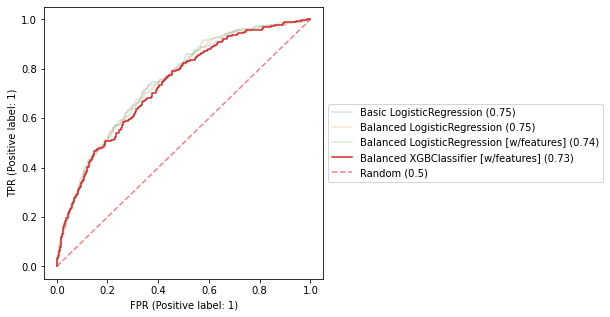

--- PRECISION RECALL AUC ---



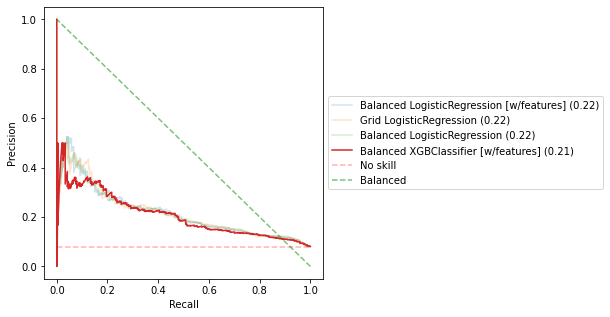

In [175]:
get_scores(f"{model_name} [w/features]", **grd_xgb, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [176]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.21011927454931653) for this model is reached with a threshold of 0.364


--- Balanced XGBClassifier [w/thresholding & features] ---

             ROC_AUC : 0.7329
                  F1 : 0.2019
            ACCURACY : 0.4467
           PRECISION : 0.1141
              RECALL : 0.8750
   AVERAGE_PRECISION : 0.2084

----------------------------------------------------------------------------------------------------
      The informations below this line are based on the best estimator of the cross-validation      
----------------------------------------------------------------------------------------------------

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.41      0.58      2760
Prediction = 1       0.11      0.88      0.20       240

      accuracy                           0.45      3000
     macro avg       0.54      0.64      0.39      3000
  weighted avg       0.91      0.45      0.55      3000

--- Confusion Matrix ---



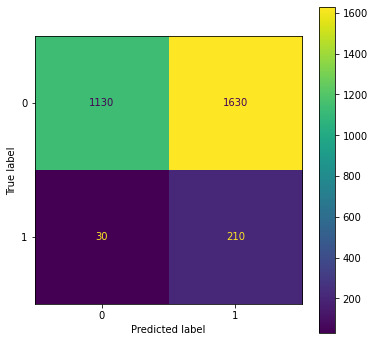

In [177]:
get_scores(f"{model_name} [w/thresholding & features]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

In [178]:
sms.send()

JupyterScriptCompleted: Jupyter is waiting

# Custom metric <a class="anchor" id="custom_metric"></a> [⇪](#menu)

## 1. The problem <a class="anchor" id="custom_metric_problem"></a> [⇪](#menu)

>#### Let's interpret the four correlation matrix values in regards to this project:
> - `(TP) True Positive` : the client is predicted as NOT OK and it really is NOT OK. *(we **save** money)*
> - `(TN) True Negative` : the client is predicted as OK and it really is OK. *(we **earn** money)*
> - `(FP) False Positive` : the client is predicted as OK but it is in fact NOT OK. *(we **miss** money)*
> - `(FN) False Negative` : the client is predicted as NOT OK but it is in fact OK. *(we **lose** money)*
>
>#### So the goals in order of importance are:
> 1. minimize the `(FN) False Negative` to **avoid losing money**.
> 2. maximize the `(TN) True Negative` to **earn money**.
> 3. maximize the `(TP) True Positive` to save money.
> 4. minimize the `(FP) False Positive` to avoid missing money.

>#### Currently we are using the F1-measure and the ROC-AUC score.
>
> - The `F1-Measure` **balance the weight** on PRECISION and RECALL.
> - The `ROC AUC score`  summarize the **trade-off** between the true positive rate (RECALL) and false positive rate (ANTI-SPECIFICITY).
>

> RECALL = $\frac{TP}{TP + FN}$
> - High RECALL favors TP over FN
> - Low RECALL favors FN over TP

> PRECISION = $\frac{TP}{TP + FP}$
> - High PRECISION favors TP over FP
> - Low PRECISION favors FP over TP

> ANTI-SPECIFICITY = 1 - SPECIFICITY = 1 - $\frac{TN}{TN + FS}$ = $\frac{FP}{FP + TN}$
> - High ANTI-SPECIFICITY favors FP over TN
> - Low ANTI-SPECIFICITY favors TN over FP

## 2. F-measure <a class="anchor" id="custom_metric_solution"></a> [⇪](#menu)

> * `F0.5-Measure`: **More weight on precision**, less weight on recall.
> * `F1-Measure`  : **Balance the weight** on precision and recall.
> * `F2-Measure`  : **More weight on recall**, less weight on precision.

>#### And luckily, there exists a [Fbeta-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) function in sklearn, which can be used to reproduce those F-measure and any in between measure... So we can in fact decide how much weight we want to give to RECALL.

>#### We want to maximize this `Fbeta-score` with beta > 1.0 !

In [ ]:
from sklearn.metrics import fbeta_score
fb_score = fbeta_score(y_test, y_pred_log, beta=2.0)
fb_score

In [ ]:
import FreeMobileSMS as sms
sms.send()

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
def my_loss(xvals, yvals, validation=False):
    print(xvals.index, yvals, validation)
    return 1.0

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
grd_dt = fit_model(
    DecisionTreeClassifier(), 
    param_grid={ 'random_state':[0] }, 
    cv = skfold,
    scoring="custom"
)

In [ ]:
get_scores(f"Basic {get_model_name(grd_dt['model'])}", **grd_dt, register=True)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci